# Denoising-CNN

## 1. 构建通用类

In [1]:
import os
import time
import torch
from torch import nn
import torch.utils.data as td
from abc import ABC, abstractmethod
import random

In [2]:
# 定义一个基本的基础的网络
class NeuralNetwork(nn.Module, ABC):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
    
    @property
    def device(self):
        return next(self.parameters()).device

    @abstractmethod
    def forward(self, x):
        pass
    @abstractmethod
    def criterion(self, voutput, vtarget):
        pass

In [3]:
# 定义一个管理网络中参数的管理器
class StatsManager(object):
    def __init__(self):
        self.init()
        
    def __repr__(self):
        return self.__class__.__name__
    
    def init(self):
        self.running_loss=0
        self.number_update=0
        
    def accumulate(self, loss, vinput=None, voutput=None, vtarget=None):
        self.running_loss+=loss
        self.number_update+=1
    
    def summarize(self):
        return self.running_loss/self.number_update

In [4]:
# 定义一个训练的类
class Experiment(object):
    def __init__(self, net, train_set, val_set, optimizer, stats_manager, 
                output_dir = None, batch_size = 16):
    
        # Define data Loaders
        # shuffle=True 在每个新的epoch里面会重新打乱形成新的batch
        # drop_last=True 当样本数量被分割成多个batch的时候，如果还有多的数据（少于batchsize），那么这些样本会被扔掉
        # pin_memory=True 让每个batch形成的张量能更快进入到cuda中
        self.train_loader = td.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
        self.val_loader = td.DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        # Define history
        self.history = []

        # Define checkpoint paths
        if output_dir is None:
            output_dir = "Denoising_{}".format(time.time())
        os.makedirs(output_dir, exist_ok=True)
        checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        config_path = os.path.join(output_dir, "config.txt")

        # 将全局变量全部转化成字典形式
        maps = {k:v for k, v in locals().items() if k != 'self'}
        self.__dict__.update(maps)

        # 存储checkpoint或者继续加载模型
        if os.path.isfile(self.config_path):
            with open(config_path, 'r') as f:

                if (f.read()[:-1] != repr(self)):
                    raise ValueError(
                            "Cannot create this experiment: "
                            "I found a checkpoint conflicting with the current setting.")
                else:
                    self.load()
        else:
            self.save()
    
    # 获取当前的epoch
    @property
    def epoch(self):
        return len(self.history)
    
    # 获取当前的网络的配置，用字典返回
    def setting(self):
        return {'Net': self.net,
                'TrainSet': self.train_set,
                'ValSet': self.val_set,
                'Optimizer': self.optimizer,
                'StatsManager': self.stats_manager,
                'BatchSize': self.batch_size}   
    
    # 重写repr内置函数，用字符串的形式返回当前网络的配置
    def __repr__(self):
        string = ''
        for k, v in self.setting().items():
            if(k == 'TrainSet' or k == 'ValSet'):
                v = "Size is " + str(len(v))
            string += '{} : {} \n'.format(k, v)
        return string
    
    # 返回当前网络训练的状态，用字典的形式
    def state_dict(self):
        return {'Net': self.net.state_dict(),
                'Optimizer': self.optimizer.state_dict(),
                'History': self.history}
        
        
    # 将网络模型(重写的repr返回值)保存在config_path中，同时将网络的state_dict（参数什么的）保存到checkpoint_path
    def save(self):
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)
    
    
    # 读取检查点，进行装载
    def load(self):
        checkpoint = torch.load(self.checkpoint_path, map_location=self.net.device)
        self.net.load_state_dict(checkpoint['Net'])
        self.optimizer.load_state_dict(checkpoint['Optimizer'])
        self.history = checkpoint['History']
#         for state in self.optimizer.state.values():
#             for k, v in state.items():
#                 if isinstance(v, torch.Tensor):
#                     state[k] = v.to(self.net.device)
        del checkpoint
        
        
    def run(self, num_epochs, plot=None):
        # 设置网络的状态是train状态(mode=True)，而不是eval状态(mode=False)，这只对某些特定的模块有作用
        self.net.train(mode=True)
        self.stats_manager.init()
        start_epoch = self.epoch
        print("Start/Continue training from epoch {}".format(start_epoch))
        
#         if(plot is not None):
#             plot(self)
        
        for epoch in range(start_epoch, num_epochs):
            s = time.time()
            # 每一个新的epoch都要重新计算loss
            self.stats_manager.init()
            for vinput, vtarget in self.train_loader:
                # 将变量挂载到CPU或者GPU
                vinput = vinput.to(self.net.device)
                vtarget = vtarget.to(self.net.device)
                # 将优化器里面的梯度全部清空
                self.optimizer.zero_grad()
                # 开始前向传播
                voutput = self.net.forward(vinput)
                # 计算loss
                loss = self.net.criterion(voutput, vtarget)
                # 根据loss计算梯度
                loss.backward()
                # 利用优化器进行单次权值w更新
                self.optimizer.step()
                
                # loss.item()是将loss这个零维张量转化成浮点数
                with torch.no_grad():
                    self.stats_manager.accumulate(loss.item(), vinput, voutput, vtarget)
            # 将每次epoch中的loss加入到history中    
            self.history.append(self.stats_manager.summarize())
            # 输出每一轮的loss
            print('Epoch {}  Time:{}  Loss:{}'.format(self.epoch, time.time()-s, self.stats_manager.summarize()))
            # 每一个epoch后都对模型和训练过程进行保存
            self.save()
            if plot is not None:
                plot(self)
                
        print("Finish training for {} epochs".format(num_epochs))
            
    
    def evaluate(self):
        self.stats_manager.init()
        # 指定是eval模式
        self.net.eval()
        with torch.no_grad():
            for vinput, vtarget in self.val_loader:
                vinput = vinput.to(self.net.device)
                vtarget = vtarget.to(self.net.device)
                voutput = self.net.forward(vinput)
                loss = self.net.criterion(voutput, vtarget)
                self.stats_manager.accumulate(loss.item(), vinput, voutput, vtarget)
        return self.stats_manager.summarize()

In [5]:
# 设置跑网络的设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 2. 准备数据集

In [6]:
%matplotlib inline
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import maxabs_scale, MaxAbsScaler
import copy

制造训练集相关类

In [7]:
# 对训练集和测试集进行预处理
class GetTraindata:
    def __init__(self, path):
        clean_filenames = [filename for filename in os.listdir(os.path.join(path, '干净信号txt')) if os.path.isfile(os.path.join(path, '干净信号txt', filename))]
        noisy_filenames = [filename for filename in os.listdir(os.path.join(path, '带噪信号txt')) if os.path.isfile(os.path.join(path, '带噪信号txt', filename))]
        clean_filenames.sort(key = lambda x:int(x[:-4])) 
        noisy_filenames.sort(key = lambda x:int(x[:-4]))
        clean_signal = []
        noisy_signal = []
        for file_name in clean_filenames:
            clean_signal.append(np.loadtxt(os.path.join(path, '干净信号txt', file_name)))
        for file_name in noisy_filenames:
            noisy_signal.append(np.loadtxt(os.path.join(path, '带噪信号txt', file_name)))
        
        clean_signal = np.array(clean_signal)
        noisy_signal = np.array(noisy_signal)
        
#         进行归一化处理， fit_transforn进行计算数据集固有属性（fit），同时进行转化， tranform在已经计算好的fit上进行转化， invers_tainsform()将数据集转化回来
#         self.max_abs_scaler = MaxAbsScaler()
#         data = np.concatenate((clean_signal,noisy_signal),axis=0)
#         self.max_abs_scaler.fit(data)
#         clean_signal = self.max_abs_scaler.transform(clean_signal)
#         noisy_signal = self.max_abs_scaler.transform(noisy_signal)
        
        
        
#         clean_signal = maxabs_scale(clean_signal, axis=1)
#         noisy_signal = maxabs_scale(noisy_signal)
        
        # 将一维信号转化成[通道数， 长， 宽]格式
        self.clean_signal = clean_signal[:, np.newaxis, :]
        self.noisy_signal = noisy_signal[:, np.newaxis, :]
        
#     def get_scaler(self):
#         return self.max_abs_scaler
    
    def get_data(self):
        return self.clean_signal, self.noisy_signal
    
#     def get_origin_data(self):
#         clean_orgin_signal = self.max_abs_scaler.inverse_transform(clean_signal)
#         noisy_orgin_signal = self.max_abs_scaler.inverse_transform(noisy_signal)

In [8]:
# 将数据装载到clean当中, data为数据集合， 为eval模式下的数据数量:总数据量/num
class GetDataset(Dataset):
    def __init__(self, data, num):
        self.mode = ""   # train模式使用train数据， eval模式使用eval数据
        self.eval_clean_signal = []
        self.train_clean_signal = []
        self.eval_noisy_signal = []
        self.train_noisy_signal = []
        clean_signal = data[0]
        noisy_signal = data[1]
        # 构造训练集和测试集
        count = 0
        for i in clean_signal:
            count += 1
            if(count%num == 0):
#            if((count > 500 and count < 1000) or (count > 3000 and count < 4000)):
                self.eval_clean_signal.append(i)
            else:
                self.train_clean_signal.append(i)
        
        count = 0
        for i in noisy_signal:
            count += 1
            if(count%num == 0 ):
 #           if((count > 500 and count < 1000) or (count > 3000 and count < 4000)):
                self.eval_noisy_signal.append(i)
            else:
                self.train_noisy_signal.append(i)    
        

                
    
    # 返回的是一个2*1*2001   ([1, 2001], [1, 2001])
    def __getitem__(self, index):
        clean = []
        noisy = []
        if(self.mode == "train"):
            clean = self.train_clean_signal[index]
            noisy = self.train_noisy_signal[index]
        elif(self.mode == "eval"):
            clean = self.eval_clean_signal[index]
            noisy = self.eval_noisy_signal[index]
        
        #归一化，返回值为归一化后的数据 
        clean = maxabs_scale(clean, axis=1)
        noisy = maxabs_scale(noisy, axis=1)
        
        clean = torch.Tensor(clean)
        noisy = torch.Tensor(noisy)
        
        return noisy, clean
    
    def __len__(self):
        if(self.mode == "train"):
            return len(self.train_clean_signal)
        else:
            return len(self.eval_clean_signal)
            
    def train(self):
        self.mode = "train"
        self.eval_clean_signal = []
        self.eval_noisy_signal = []
        return self.mode
        
    def eval(self):
        self.mode = "eval"
        self.train_clean_signal = []
        self.train_noisy_signal = []
        return self.mode

导入数据集

In [9]:
dataset_path = "./dataset"

In [10]:
data = GetTraindata(dataset_path)
data_set = GetDataset(data.get_data(), 10)

train_set = copy.deepcopy(data_set)
train_set.train()

test_set = copy.deepcopy(data_set)
test_set.eval()

'eval'

In [11]:
len(test_set)

50

In [12]:
train_set[0][1]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0004, 0.0004, 0.0002]])

In [13]:
# 设计一个我的画图
def mysignalshow(signal, ax = plt):
#     将归一化后的数据进行还原的信号
#    signal = data.max_abs_scaler.inverse_transform(signal.to('cpu').numpy())[0]
    # 转化成cpu
    signal = signal.to('cpu').numpy()[0]
    ax.plot(signal)

看下测试集图像

In [14]:
# for i in range(len(test_set)):
#     plt.clf()
#     mysignalshow(test_set[i][1])
#     plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\测试集图形\{}.svg'.format(i))

In [15]:
# for i in range(len(train_set)):
#     plt.clf()
#     mysignalshow(train_set[i][1])
#     plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\训练集图像\{}.svg'.format(i))

## 3.1. DnCNN

实现DnCNN的网络

In [16]:
class DnCNN(NeuralNetwork):
    def __init__(self, D , C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        # 用于保留最后一个batch中所有的特征
        self.features = []
        
        # 开始搭建卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(1, C, 3, padding = 1))
        self.conv.extend([nn.Conv1d(C, C, 3, padding = 1) for _ in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding = 1))
        
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv)):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # 设置bn层
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C) for _ in range(D)])
        for i in range(len(self.bn)):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
            
    def forward(self, vinput):
        self.features.clear()
        D = self.D
        h = F.leaky_relu(self.conv[0](vinput))
        self.features.append(h)
        for i in range(D):
            h = F.leaky_relu(self.bn[i](self.conv[i+1](h)))
            self.features.append(h)
        voutput = self.conv[D+1](h) + vinput
        return voutput
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)

随便跑一跑

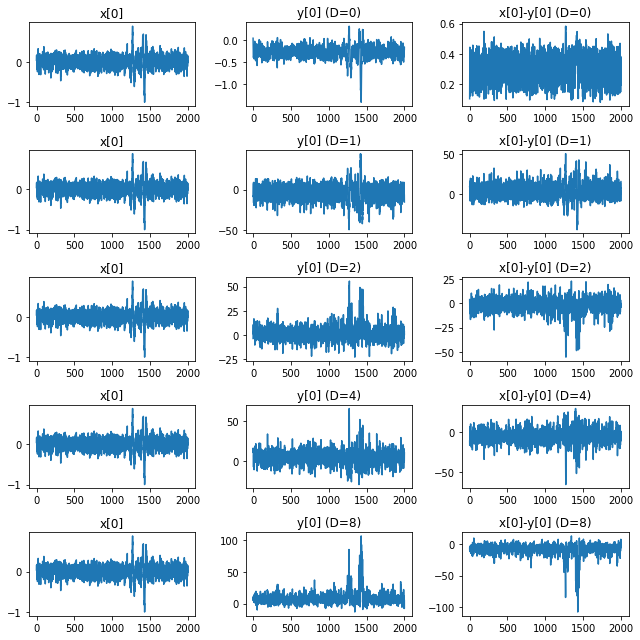

In [17]:
x,t = train_set[0]
# 给数据添加一个维度来代表batch-size
x = x.unsqueeze(0).to(device)
Dnum = [0, 1, 2, 4, 8]



fig, axes = plt.subplots(nrows=len(Dnum), ncols = 3, figsize=(9, 9))
for i in range(len(Dnum)):
    with torch.no_grad():
        model = DnCNN(Dnum[i]).to(device)
        y = model(x)

    mysignalshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    mysignalshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Dnum[i]})')
    mysignalshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Dnum[i]})')
#     mysignalshow(t, ax=axes[i][3])
#     axes[i][3].set_title(f'clean (D={Dnum[i]})')
    plt.tight_layout()



实现下DnCNN的StatsManager

In [18]:
class DenoisingStatsManager(StatsManager):
    def __init__(self):
        super(DenoisingStatsManager, self).__init__()
    
    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0
        
    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d) 
        n = x.shape[0] * x.shape[1] * x.shape[2] 
        self.running_psnr += 10*torch.log10(3*n/(torch.norm(y-d)**2))
        
    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [19]:
def plot(exp, fig, axes, noisy, clean, visu_rate=2):
#     if(exp.epoch != 200):
#         return 
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()

    mysignalshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy signal')
    
    mysignalshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised signal')
    
    mysignalshow(clean, ax=axes[0][2])
    axes[0][2].set_title('Clean signal')
    
    axes[1][0].plot([exp.history[k]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

DnCNN开始训练

In [20]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising1")

Start/Continue training from epoch 200
Finish training for 200 epochs


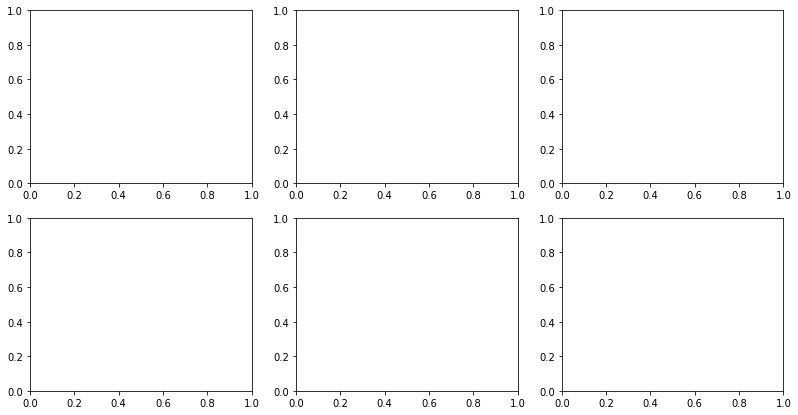

In [289]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("DnCNN_PSNR"))

## 3.3 DenseNet

In [22]:
class DenseNet(NeuralNetwork):
    def __init__(self, D , C=64):
        super(DenseNet, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        # 用于保留最后一个batch中所有的特征
        self.features = []
        
        # 开始搭建卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(1, C, 3, padding = 1))
        for i in range(D):
            self.conv.append(nn.Conv1d(C*(i+1)+1, C, 3, padding = 1))
        self.conv.append(nn.Conv1d(C*(D+1)+1, 1, 3, padding = 1))
        
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv)):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # 设置bn层
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C) for _ in range(D)])
        for i in range(len(self.bn)):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
            
    def forward(self, vinput):
        self.features.clear()
        D = self.D
        h = F.leaky_relu(self.conv[0](vinput))
        self.features.append(h)
        for i in range(D):
            h = torch.cat((vinput, h), dim=1)
            for j in range(len(self.features)-1):
                h = torch.cat((self.features[j], h), dim=1)
            h = F.leaky_relu(self.bn[i](self.conv[i+1](h)))
            self.features.append(h)
        h = torch.cat((vinput,h), dim=1)
        for j in range(len(self.features)-1):
            h = torch.cat((self.features[j],h), dim=1)
        voutput = self.conv[D+1](h) + vinput
        return voutput
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)

In [23]:
lr = 1e-3
net = DenseNet(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp6 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising6")

Start/Continue training from epoch 200
Finish training for 200 epochs


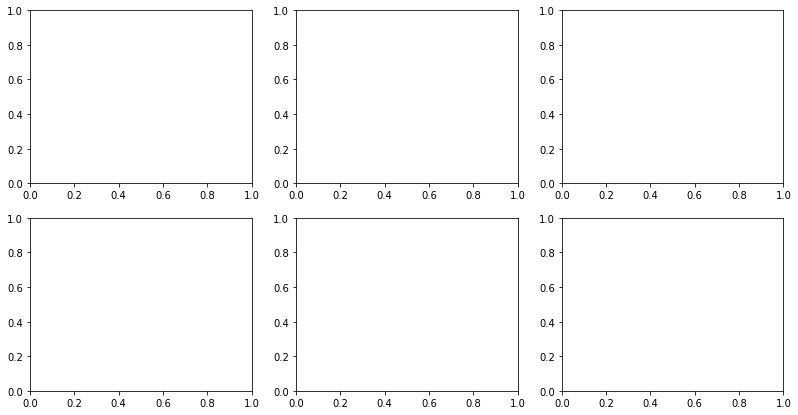

In [24]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp6.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("DenseNet"))

## 4. UDnCNN

In [25]:
class UDnCNN(NeuralNetwork):
    def __init__(self, D , C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        self.features = []
        
        # 开始搭建卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(1, C, 3, padding = 1))
        self.conv.extend([nn.Conv1d(C, C, 3, padding = 1) for _ in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding = 1))
        
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv)):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # 设置bn层
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C) for _ in range(D)])
        for i in range(len(self.bn)):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
    # 前面都一样，这里搞个U-Net        
    def forward(self, vinput):
        self.features.clear()
        D = self.D
        h = F.leaky_relu(self.conv[0](vinput))
        self.features.append(h)
        h_buff = []
        idx_buff = []
        shape_buff = []
        for i in range(D//2-1):
            shape_buff.append(h.shape)
            h, idx = F.max_pool1d(F.leaky_relu(self.bn[i](self.conv[i+1](h))),
                                 kernel_size=3, return_indices=True)
            h_buff.append(h)
            self.features.append(h)
            idx_buff.append(idx)
        for i in range(D//2-1, D//2+1):
            h = F.leaky_relu(self.bn[i](self.conv[i+1](h)))
            self.features.append(h)
        for i in range(D//2+1, D):
            j = i - (D//2+1) + 1
            h = F.max_unpool1d(F.leaky_relu(self.bn[i](self.conv[i+1]((h+h_buff[-j])/np.sqrt(2)))), 
                               idx_buff[-j], kernel_size=3, output_size=shape_buff[-j])
            self.features.append(h)
        voutput = self.conv[D+1](h) + vinput
        return voutput
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)

UDnCNN训练

In [26]:
lr = 1e-3
net = UDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp2 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising2")

Start/Continue training from epoch 200
Finish training for 200 epochs


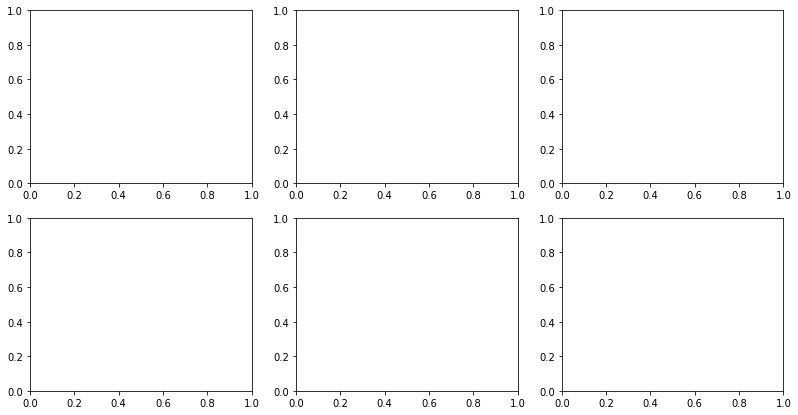

In [27]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp2.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("UDnCNN_PSNR"))

## 5. DUDnCNN
U-net like CNNs with dilated convolutions

空洞卷积(dilated convolution)代替池化来增大感受野(Receptive Field)

然而 pytorch 空洞卷积跑的贼慢，原理上看应该和普通卷积差不多快，这里有个优化的问题...

空洞卷积之前 torch.backends.cudnn.benchmark=True 之后改回 torch.backends.cudnn.benchmark=False 可以提速，详见 https://github.com/pytorch/pytorch/issues/15054.

In [28]:
class DUDnCNN(NeuralNetwork):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        self.features = []
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # 空洞卷积
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # 卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(1, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv1d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding=dilations[-1], dilation=dilations[-1]))
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # batch norm
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C, C) for _ in range(D)])
        # Batch norm layer 初始化权值
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        self.features.clear()
        D = self.D
        h = F.leaky_relu(self.conv[0](x))
        self.features.append(h)
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            h_buff.append(h)
            self.features.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            self.features.append(h)
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            self.features.append(h)
            
        y = self.conv[D+1](h) + x
        return y
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)

In [29]:
lr = 1e-3
net = DUDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising3")

Start/Continue training from epoch 200
Finish training for 200 epochs


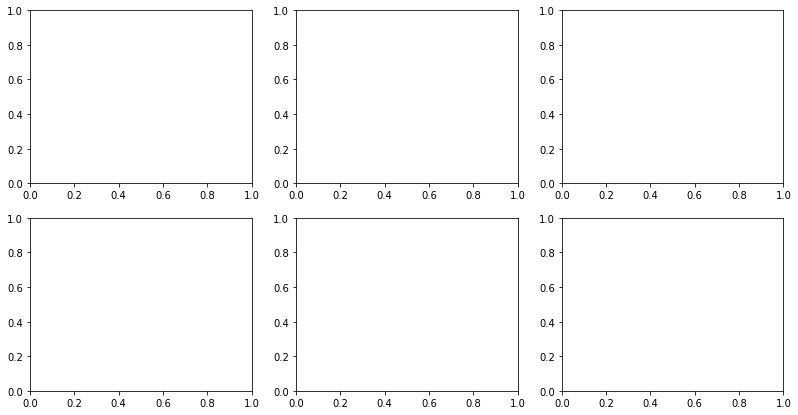

In [30]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp3.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("DUDnCNN_PSNR"))

## 6.1. FDUDnCNN

In [31]:
class FDUDnCNN(NeuralNetwork):
    def __init__(self, D, C=64):
        super(FDUDnCNN, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        self.features = []
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # 空洞卷积
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # 卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(2, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv1d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding=dilations[-1], dilation=dilations[-1]))
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # batch norm
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C, C) for _ in range(D)])
        # Batch norm layer 初始化权值
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
        
        self.FCN_init(D, C)
 
    def FCN_init(self, D, C):
        self.FCN = nn.ModuleList()
        self.FCN.append(nn.Conv1d(1, C, 3,dilation=2,  padding=2))
        self.FCN.append(nn.Conv1d(C, C, 3,dilation=3,  padding=3))
        self.FCN.append(nn.Conv1d(C, C, 3,dilation=5,  padding=5))
        self.FCN.append(nn.Conv1d(C, C, 3,dilation=2,  padding=2))
        self.FCN.append(nn.Conv1d(C, C, 3,dilation=3,  padding=3))
        self.FCN.append(nn.Conv1d(C, 1, 3,dilation=5,  padding=5))
        
        # 初始化 
        for i in range(len(self.FCN)):
            nn.init.kaiming_normal_(self.FCN[i].weight.data, nonlinearity='leaky_relu')

    def FCN_forward(self, x):
        h = x
        for i in range(len(self.FCN)):
            h = self.FCN[i](h)
            h = F.leaky_relu(h)
        self.estimate_noisy = h
        return h            

    def forward(self, x):
        self.features.clear()
        D = self.D
        # 得出噪声估计
        h = self.FCN_forward(x)
        h = torch.cat((x, h), dim=1)
        
        h = F.leaky_relu(self.conv[0](h))
        self.features.append(h)
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            h_buff.append(h)
            self.features.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            self.features.append(h)
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            # h = (h + h_buff[-j]) / np.sqrt(2) # 跳层连接
            h = self.conv[i+1](h) 
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            self.features.append(h)
        

        y = self.conv[D+1](h) + x
        return y
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)+0.5 * torch.mean(torch.mul(torch.abs(0.3 - F.relu(vtarget - self.estimate_noisy - voutput)),torch.pow(self.estimate_noisy + voutput - vtarget, 2)))
        

        

In [32]:
lr = 1e-3
net = FDUDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp4 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising4")

Start/Continue training from epoch 200
Finish training for 200 epochs


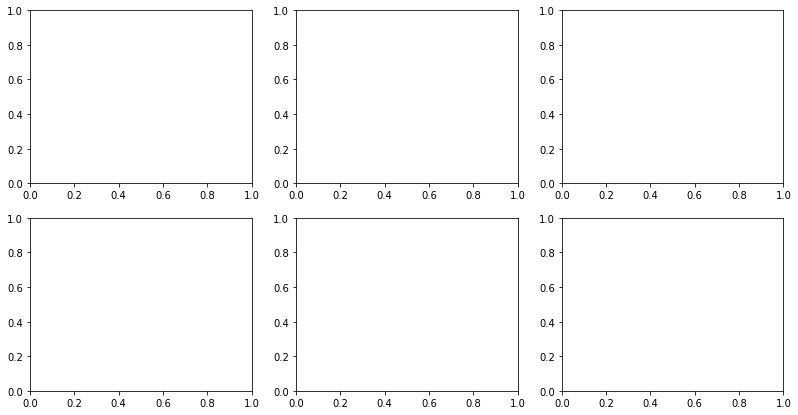

In [33]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp4.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("FDUDnCNN_PSNR"))

## 6.2 FDUDnCNN_improve

In [360]:
class FDUDnCNN_improve(NeuralNetwork): # CBDNet+DUDnCNN融合

    def __init__(self, D, C=64):
        super(FDUDnCNN_improve, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        self.features = []
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # 空洞卷积
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # 卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(2, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv1d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding=dilations[-1], dilation=dilations[-1]))
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # batch norm
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C, C) for _ in range(D)])
        # Batch norm layer 初始化权值
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
        
        self.FCN_init(D, C)
 
    def FCN_init(self, D, C):
        self.FCN = nn.ModuleList()
        self.FCN.append(nn.Conv1d(1, C, 1,dilation=1,  padding=0)) # 0
        
        for i in range(2):
            self.FCN.append(nn.Conv1d(C, C, 1,dilation=2,  padding=0)) # 1 4
            self.FCN.append(nn.Conv1d(C, C, 1,dilation=3,  padding=0)) # 2 5
            self.FCN.append(nn.Conv1d(C, C, 1,dilation=5,  padding=0)) # 3 6
        
        for i in range(2):
            self.FCN.append(nn.Conv1d(C, C, 3,dilation=2,  padding=2)) # 7 10
            self.FCN.append(nn.Conv1d(C, C, 3,dilation=3,  padding=3)) # 8 11
            self.FCN.append(nn.Conv1d(C, C, 3,dilation=5,  padding=5))# 9 12   
        
        for i in range(2):
            self.FCN.append(nn.Conv1d(C, C, 5,dilation=2,  padding=4)) #13 16
            self.FCN.append(nn.Conv1d(C, C, 5,dilation=3,  padding=6)) #14 17
            self.FCN.append(nn.Conv1d(C, C, 5,dilation=5,  padding=10))#15 18          
        
        self.FCN.append(nn.Conv1d(C, C, 1,dilation=1,  padding=0)) # 19
        self.FCN.append(nn.Conv1d(C, 1, 1,dilation=1,  padding=0))# 20
        
        # 初始化 
        for i in range(len(self.FCN)):
            nn.init.kaiming_normal_(self.FCN[i].weight.data, nonlinearity='leaky_relu')

    def FCN_forward(self, x):
        h = x
        h = F.leaky_relu(self.FCN[0](h))
 
        h1 = F.leaky_relu(self.FCN[1](h))
        h1 = F.leaky_relu(self.FCN[2](h1))

        h2 = F.leaky_relu(self.FCN[7](h))
        h2 = F.leaky_relu(self.FCN[8](h2))

        h3 = F.leaky_relu(self.FCN[13](h))
        h3 = F.leaky_relu(self.FCN[14](h3))
        
        remain1 = h1
        remain2 = h2
        remain3 = h3

        h1 = F.leaky_relu(self.FCN[3]((remain1+remain2+remain3)/np.sqrt(3)))    
        h2 = F.leaky_relu(self.FCN[9]((remain1+remain2+remain3)/np.sqrt(3)))  
        h3 = F.leaky_relu(self.FCN[15]((remain1+remain2+remain3)/np.sqrt(3))) 
        
        #-------------------------------------------------------------------
        h1 = F.leaky_relu(self.FCN[4](h1))
        h1 = F.leaky_relu(self.FCN[5](h1))

        h2 = F.leaky_relu(self.FCN[10](h2))
        h2 = F.leaky_relu(self.FCN[11](h2))

        h3 = F.leaky_relu(self.FCN[16](h3))
        h3 = F.leaky_relu(self.FCN[17](h3))
        
        remain1 = h1
        remain2 = h2
        remain3 = h3
        
        h1 = F.leaky_relu(self.FCN[6]((remain1+remain2+remain3)/np.sqrt(3))) 
        h2 = F.leaky_relu(self.FCN[12]((remain1+remain2+remain3)/np.sqrt(3))) 
        h3 = F.leaky_relu(self.FCN[18]((remain1+remain2+remain3)/np.sqrt(3))) 
        
        h = F.leaky_relu(self.FCN[19]((h1+h2+h3)/np.sqrt(3)))    
        h = F.leaky_relu(self.FCN[20](h))  

        
        self.estimate_noisy = h
        return h            

    def forward(self, x):
        self.features.clear()
        D = self.D
        # 得出噪声估计
        h = self.FCN_forward(x)
        h = torch.cat((x, h), dim=1)
        
        h = F.leaky_relu(self.conv[0](h))
        self.features.append(h)
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            self.features.append(h)
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            h_buff.append(h)
            self.features.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            self.features.append(h)
            # h = torch.cat((x, h), dim=1)
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            self.features.append(h)
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            self.features.append(h)
            h = self.conv[i+1](h) 
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            
        
        # h = torch.cat((x, h), dim=1)
        y = self.conv[D+1](h) + x
        return y
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)+0.5 * torch.mean(torch.mul(torch.abs(0.3 - F.relu(vtarget - self.estimate_noisy - voutput)),torch.pow(self.estimate_noisy + voutput - vtarget, 2)))
        

        

In [361]:
lr = 1e-3
net = FDUDnCNN_improve(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp8 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising8")

Start/Continue training from epoch 200
Finish training for 200 epochs


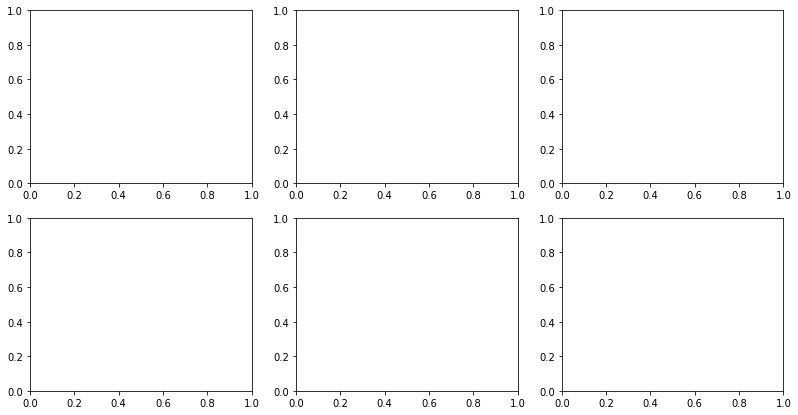

In [362]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp8.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("FDUDnCNN_improve_PSNR"))

## 6.3. FDUDDnCNN

In [29]:
class FDUDDnCNN(NeuralNetwork): # CBDNet+DUDnCNN融合

    def __init__(self, D, C=64):
        super(FDUDDnCNN, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        self.features = []
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # 空洞卷积
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # 卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(2, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv1d(C+1, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv1d(C+1, 1, 3, padding=dilations[-1], dilation=dilations[-1]))
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # batch norm
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C, C) for _ in range(D)])
        # Batch norm layer 初始化权值
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
        
        self.FCN_init(D, C)
 
    def FCN_init(self, D, C):
        self.FCN = nn.ModuleList()
        self.FCN.append(nn.Conv1d(1, C, 1,dilation=1,  padding=0)) # 0
        
        for i in range(2):
            self.FCN.append(nn.Conv1d(C, C, 1,dilation=2,  padding=0)) # 1 4
            self.FCN.append(nn.Conv1d(C, C, 1,dilation=3,  padding=0)) # 2 5
            self.FCN.append(nn.Conv1d(C, C, 1,dilation=5,  padding=0)) # 3 6
        
        for i in range(2):
            self.FCN.append(nn.Conv1d(C, C, 3,dilation=2,  padding=2)) # 7 10
            self.FCN.append(nn.Conv1d(C, C, 3,dilation=3,  padding=3)) # 8 11
            self.FCN.append(nn.Conv1d(C, C, 3,dilation=5,  padding=5))# 9 12   
        
        for i in range(2):
            self.FCN.append(nn.Conv1d(C, C, 5,dilation=2,  padding=4)) #13 16
            self.FCN.append(nn.Conv1d(C, C, 5,dilation=3,  padding=6)) #14 17
            self.FCN.append(nn.Conv1d(C, C, 5,dilation=5,  padding=10))#15 18          
        
        self.FCN.append(nn.Conv1d(C, C, 1,dilation=1,  padding=0)) # 19
        self.FCN.append(nn.Conv1d(C, 1, 1,dilation=1,  padding=0))# 20
        
        # 初始化 
        for i in range(len(self.FCN)):
            nn.init.kaiming_normal_(self.FCN[i].weight.data, nonlinearity='leaky_relu')

    def FCN_forward(self, x):
        h = x
        h = F.leaky_relu(self.FCN[0](h))
 
        h1 = F.leaky_relu(self.FCN[1](h))
        h1 = F.leaky_relu(self.FCN[2](h1))

        h2 = F.leaky_relu(self.FCN[7](h))
        h2 = F.leaky_relu(self.FCN[8](h2))

        h3 = F.leaky_relu(self.FCN[13](h))
        h3 = F.leaky_relu(self.FCN[14](h3))
        
        remain1 = h1
        remain2 = h2
        remain3 = h3

        h1 = F.leaky_relu(self.FCN[3]((remain1+remain2+remain3)/np.sqrt(3)))    
        h2 = F.leaky_relu(self.FCN[9]((remain1+remain2+remain3)/np.sqrt(3)))  
        h3 = F.leaky_relu(self.FCN[15]((remain1+remain2+remain3)/np.sqrt(3))) 
        
        #-------------------------------------------------------------------
        h1 = F.leaky_relu(self.FCN[4](h1))
        h1 = F.leaky_relu(self.FCN[5](h1))

        h2 = F.leaky_relu(self.FCN[10](h2))
        h2 = F.leaky_relu(self.FCN[11](h2))

        h3 = F.leaky_relu(self.FCN[16](h3))
        h3 = F.leaky_relu(self.FCN[17](h3))
        
        remain1 = h1
        remain2 = h2
        remain3 = h3
        
        h1 = F.leaky_relu(self.FCN[6]((remain1+remain2+remain3)/np.sqrt(3))) 
        h2 = F.leaky_relu(self.FCN[12]((remain1+remain2+remain3)/np.sqrt(3))) 
        h3 = F.leaky_relu(self.FCN[18]((remain1+remain2+remain3)/np.sqrt(3))) 
        
        h = F.leaky_relu(self.FCN[19]((h1+h2+h3)/np.sqrt(3)))    
        h = F.leaky_relu(self.FCN[20](h))  

        
        self.estimate_noisy = h
        return h            

    def forward(self, x):
        self.features.clear()
        D = self.D
        # 得出噪声估计
        h = self.FCN_forward(x)
        
        hx = h
        
        h = torch.cat((x, h), dim=1)
        h = F.leaky_relu(self.conv[0](h))
        self.features.append(h)
        h_buff = []
        
        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            self.features.append(h)
            h = torch.cat((x, h), dim=1)
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            h_buff.append(h)
            
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            self.features.append(h)
            h = torch.cat((hx, h), dim=1)
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            
        
        
        
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True           
            self.features.append(h)
            h = (h + h_buff[-j]) / np.sqrt(2) # 跳层连接
            h = torch.cat((hx, h), dim=1) # 和输入连接
            h = self.conv[i+1](h) 
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            
        
        h = torch.cat((x, h), dim=1)
        y = self.conv[D+1](h) + x
        return y
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)+0.5 * torch.mean(torch.mul(torch.abs(0.3 - F.relu(vtarget - self.estimate_noisy - voutput)),torch.pow(self.estimate_noisy + voutput - vtarget, 2)))
        

        

In [30]:
lr = 1e-3
net = FDUDDnCNN(6).to(device)
Adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp7 = Experiment(net, train_set, test_set, Adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising7")

Start/Continue training from epoch 200
Finish training for 200 epochs


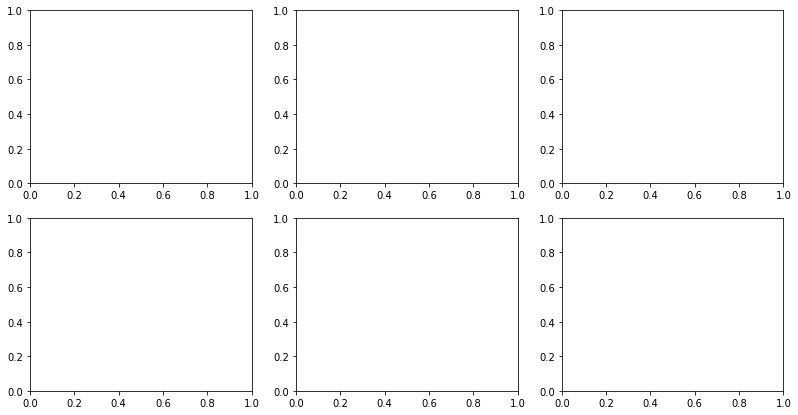

In [365]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp7.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("FDUDDnCNN_PSNR"))

In [366]:
def save_txt(title, lists): 
    path = r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\实验数据保存\论文图像数据'
    with open(os.path.join(path,title+".txt"),"w") as f:
        for i in lists:
            f.write("{:.8f}\n".format(i)) #这句话⾃带⽂件关闭功能，不需要再写f.close()

## 6. 比较网络效果

看下三个网络的loss和PSNR

In [200]:
# DnCNN
exp1.evaluate()

NameError: name 'exp1' is not defined

In [ ]:
# UDnCNN
exp2.evaluate()

In [64]:
# DUDnCNN
exp3.evaluate()

NameError: name 'exp3' is not defined

In [65]:
# CBDNet
exp4.evaluate()

NameError: name 'exp4' is not defined

看下三个网络处理的效果

In [66]:
num = 2 
signal = []
nets = [exp1.net, exp2.net, exp3.net, exp4.net]
titles = ['noisy', 'DnCNN', 'UDnCNN', 'DUDnCNN', 'FDUDnCNN']

fig, axes = plt.subplots(ncols=5, nrows=num*2, figsize=(20,10))

for i in range(num):
    mysignalshow(train_set[7*i+7][0], ax=axes[i][0])
    x, _ = test_set[7*i+7]
    x = x.unsqueeze(0).to(device)
    signal.append(x)
    
for i in range(1,num+1):
    mysignalshow(train_set[200*i+7][0], ax=axes[i+num-1][0])
    x, _ = train_set[200*i+7]
    x = x.unsqueeze(0).to(device)
    signal.append(x)  
    
for i in range(num*2):
    for j in range(len(nets)):
        model = nets[j].to(device)
        model.eval()
        with torch.no_grad():
            y = model.forward(signal[i])
        mysignalshow(y[0], ax=axes[i][j+1])
for i in range(1):
    for j in range(len(titles)):
        axes[i][j].set_title(f'{titles[j]}')

NameError: name 'exp1' is not defined

NameError: name 'exp1' is not defined

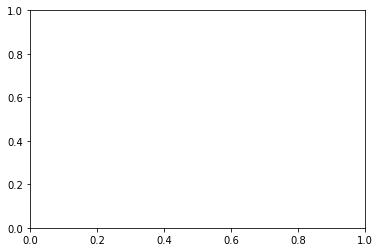

In [67]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot([exp1.history[k]['PSNR'].cpu().numpy() for k in range(exp1.epoch)], label='DnCNN')
ax.plot([exp2.history[k]['PSNR'].cpu().numpy() for k in range(exp2.epoch)], label='UDnCNN')
ax.plot([exp3.history[k]['PSNR'].cpu().numpy() for k in range(exp3.epoch)], label='DUDnCNN')
ax.plot([exp4.history[k]['PSNR'].cpu().numpy() for k in range(exp4.epoch)], label='FDUDnCNN')
# ax.plot([exp5.history[k]['PSNR'].cpu().numpy() for k in range(exp5.epoch)], label='DnCNN-DR')
ax.plot([exp6.history[k]['PSNR'].cpu().numpy() for k in range(exp6.epoch)], label='DenseNet')
ax.plot([exp7.history[k]['PSNR'].cpu().numpy() for k in range(exp7.epoch)], label='FDUDDnCNN')
ax.plot([exp7.history[k]['PSNR'].cpu().numpy() for k in range(exp8.epoch)], label='FDUDnCNN_Improve')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("PSNR")
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\对比图', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\对比图\PSNR.svg')

NameError: name 'exp3' is not defined

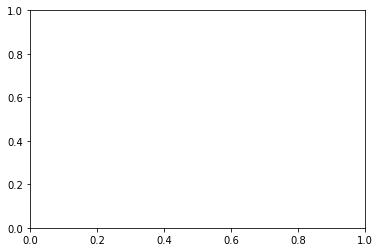

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot([exp3.history[k]['PSNR'].cpu().numpy() for k in range(exp3.epoch)], label='DUDnCNN')
ax.plot([exp4.history[k]['PSNR'].cpu().numpy() for k in range(exp4.epoch)], label='FDUDnCNN')
ax.plot([exp8.history[k]['PSNR'].cpu().numpy() for k in range(exp7.epoch)], label='FDUDDnCNN_Improve')
ax.plot([exp7.history[k]['PSNR'].cpu().numpy() for k in range(exp7.epoch)], label='FDUDDnCNN')

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("PSNR")
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\对比图', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\对比图\PSNR.svg')


In [29]:
# 保存数据
save_txt('DnCNN_PSNR', [exp1.history[k]['PSNR'].cpu().numpy() for k in range(exp1.epoch)])
save_txt('UDnCNN_PSNR', [exp2.history[k]['PSNR'].cpu().numpy() for k in range(exp2.epoch)])
save_txt('DUDnCNN_PSNR', [exp3.history[k]['PSNR'].cpu().numpy() for k in range(exp3.epoch)])
save_txt('FDUDnCNN_PSNR',[exp4.history[k]['PSNR'].cpu().numpy() for k in range(exp4.epoch)])
# save_txt('DnCNN_DenseBlock_PSNR', [exp5.history[k]['PSNR'].cpu().numpy() for k in range(exp5.epoch)])
save_txt('DenseNet_PSNR', [exp6.history[k]['PSNR'].cpu().numpy() for k in range(exp6.epoch)])
save_txt('FDUDnCNN_Improve_PSNR', [exp8.history[k]['PSNR'].cpu().numpy() for k in range(exp8.epoch)])
save_txt('FDUDDnCNN_PSNR', [exp7.history[k]['PSNR'].cpu().numpy() for k in range(exp7.epoch)])

NameError: name 'exp1' is not defined

NameError: name 'exp3' is not defined

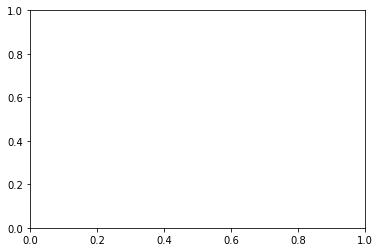

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot([exp3.history[k]['loss'] for k in range(exp3.epoch)], label='DUDnCNN')
ax.plot([exp4.history[k]['loss'] for k in range(exp4.epoch)], label='FDUDnCNN')
ax.plot([exp8.history[k]['loss'] for k in range(exp7.epoch)], label='FDUDnCNN_Improve')
ax.plot([exp7.history[k]['loss'] for k in range(exp7.epoch)], label='FDUDDnCNN')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("PSNR")
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\对比图', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\对比图\PSNR.svg')

In [ ]:
# 保存数据
save_txt('DnCNN_loss', [exp1.history[k]['loss'] for k in range(exp1.epoch)])
save_txt('UDnCNN_loss',[exp2.history[k]['loss'] for k in range(exp2.epoch)])
save_txt('DUDnCNN_loss', [exp3.history[k]['loss'] for k in range(exp3.epoch)])
save_txt('FDUDnCNN_loss', [exp4.history[k]['loss'] for k in range(exp4.epoch)])
# save_txt('DnCNN_DenseBlock_loss', [exp5.history[k]['loss'] for k in range(exp5.epoch)])
save_txt('DenseNet_loss',[exp6.history[k]['loss'] for k in range(exp6.epoch)])
save_txt('FDUDnCNN_Improve_loss', [exp8.history[k]['loss'] for k in range(exp8.epoch)])
save_txt('FDUDDnCNN_loss', [exp7.history[k]['loss'] for k in range(exp7.epoch)])

## 7. 提取特征图

In [31]:
# 设计一个我的画图
def MyFeatureShow(feature, ax = plt):
    feature = feature.cpu().detach().numpy()
#     将特征输出的通道全部相加
    feature = np.sum(feature, axis = 1)[0]
#     feature = feature[0, 1, :]
    ax.plot(feature)

In [89]:
def MyFeaturesShow(model, name, save=False):
    fig, axes = plt.subplots(2, 3, figsize = (20, 10))
    
    MyFeatureShow(model.features[0], ax=axes[0][0])
    axes[0][0].set_title('{}_conv1'.format(name))
    
    MyFeatureShow(model.features[1], ax=axes[0][1])
    axes[0][1].set_title('{}_conv2'.format(name))
    
    MyFeatureShow(model.features[2], ax=axes[0][2])
    axes[0][2].set_title('{}_conv3'.format(name))
    
    MyFeatureShow(model.features[3], ax=axes[1][0])
    axes[1][0].set_title('{}_conv4'.format(name))
    
    MyFeatureShow(model.features[4], ax=axes[1][1])
    axes[1][1].set_title('{}_conv5'.format(name))
    
    MyFeatureShow(model.features[5], ax=axes[1][2])
    axes[1][2].set_title('{}_conv6'.format(name))
    
    plt.tight_layout()
    if(save):
        os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\特征集', exist_ok=True)
        plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\特征集\{}_features.svg'.format(name))

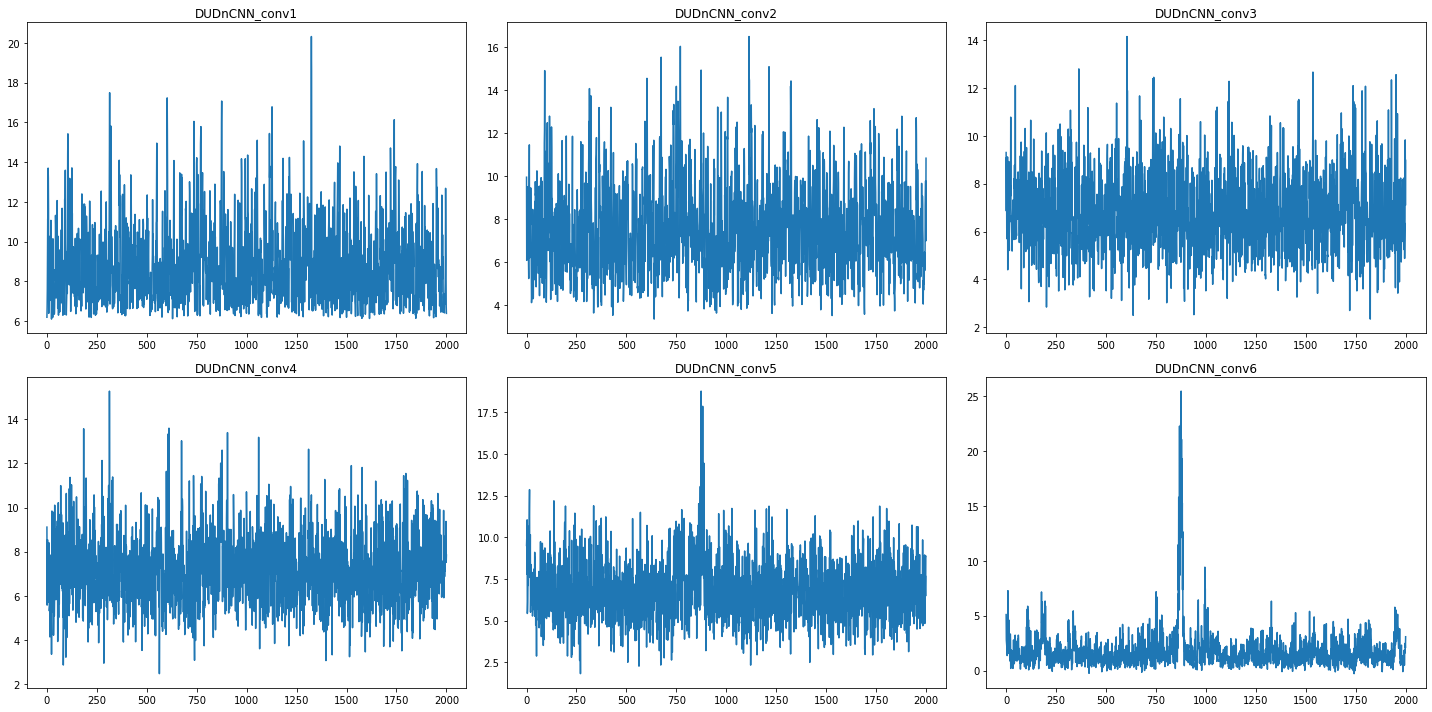

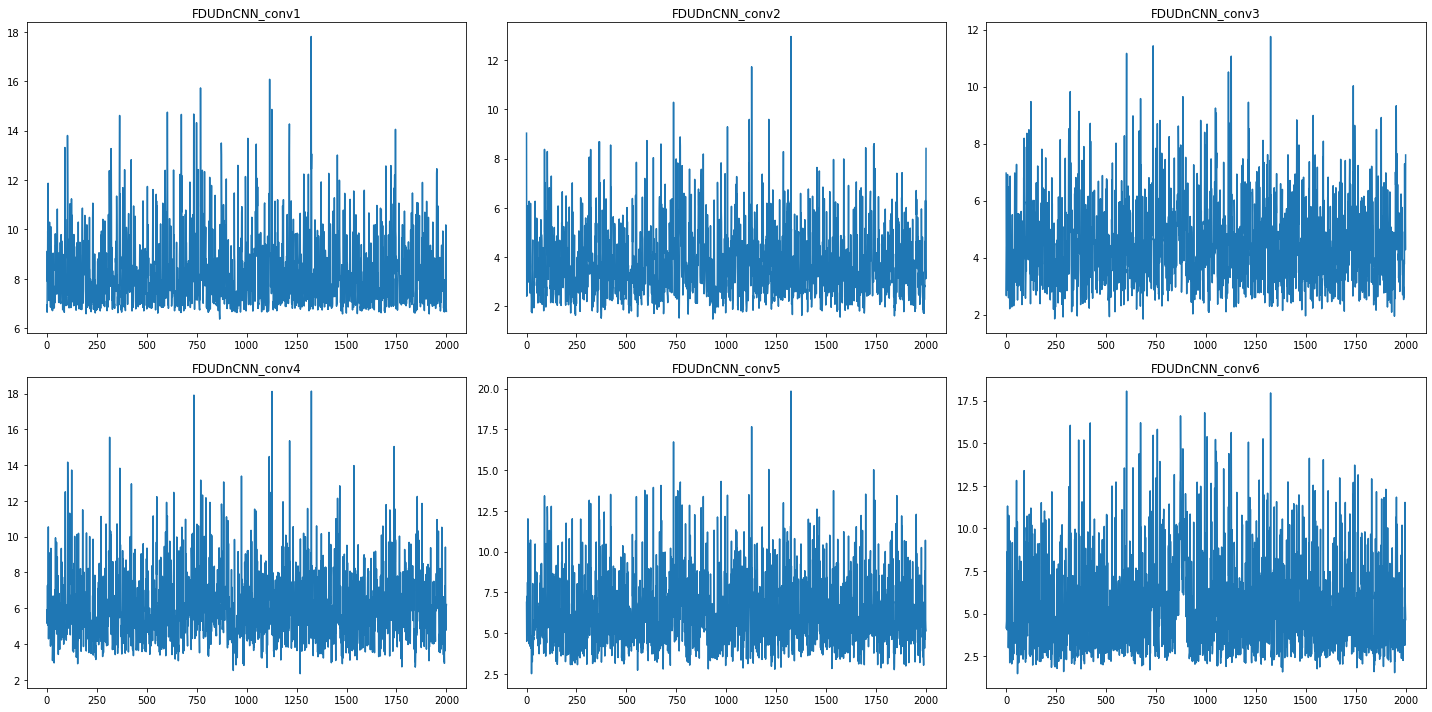

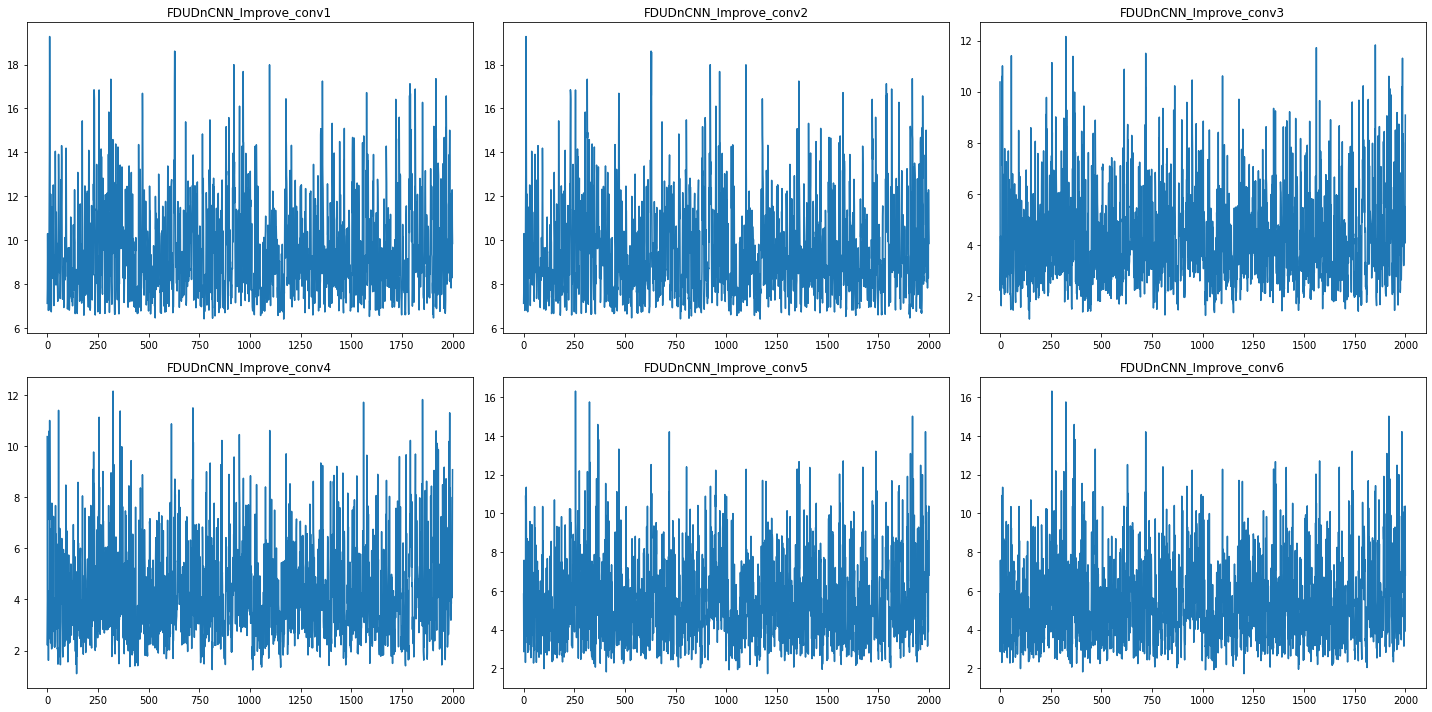

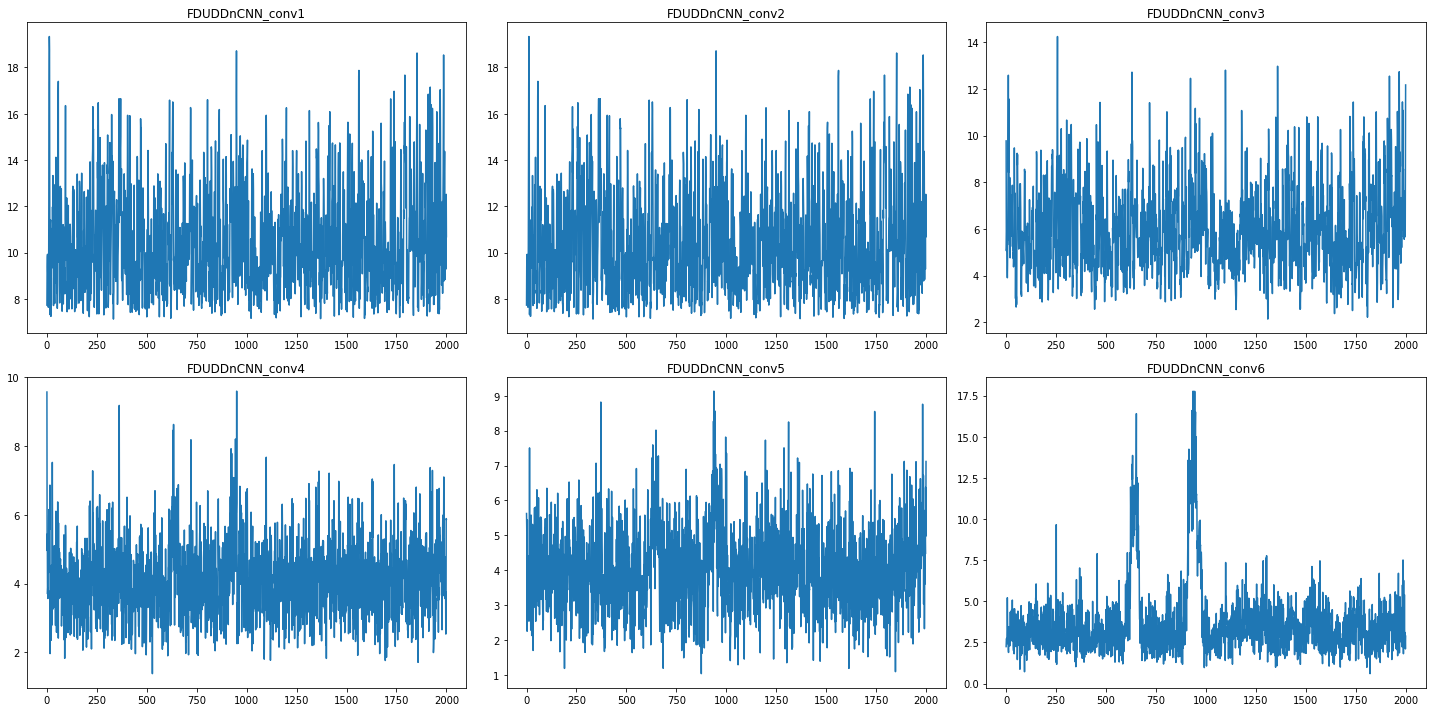

In [206]:
# MyFeaturesShow(exp1.net, "DnCNN")
# MyFeaturesShow(exp2.net, "UDnCNN")
MyFeaturesShow(exp3.net, "DUDnCNN")
MyFeaturesShow(exp4.net, "FDUDnCNN")
# MyFeaturesShow(exp5.net, "DnCNN_DenseBlock")
# MyFeaturesShow(exp6.net, "DenseNet")
MyFeaturesShow(exp8.net, "FDUDnCNN_Improve")
MyFeaturesShow(exp7.net, "FDUDDnCNN")

save_txt("FDUDnCNN_Improve_Conv3", np.sum(exp8.net.features[2].cpu().detach().numpy(), axis = 1)[0])
save_txt("FDUDDnCNN_Conv3", np.sum(exp7.net.features[2].cpu().detach().numpy(), axis = 1)[0])

## 8.保存结果集

#### 杂项

In [678]:
def mysignalshow(signal, ax = plt):
    # 将张量转化成数据
    plt.xlim(0, 2001)
    signal = data.max_abs_scaler.inverse_transform(signal.to('cpu').numpy())[0]
    ax.plot(np.array(signal))

In [679]:
nets = [exp1.net, exp2.net, exp3.net, exp4.net]
titles = ['noisy', 'DnCNN', 'UDnCNN', 'DUDnCNN', 'CBDNet']
# for i in range(len(test_set)):
#     noisy, clean = test_set[i]
#     # 信号增加一个维度， mysignal的输入是batch*2001
#     noisy = noisy.unsqueeze(0).to(device)
#     clean = clean.unsqueeze(0).to(device)
#     fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20,10))
#     # 画noisy
#     mysignalshow(noisy[0], axes[0][0])
#     axes[0][0].set_title('{}_{}'.format(titles[0], i))
# #     画clean
# #     mysignalshow(clean[0], axes[0][1])
# #     axes[0][1].set_title('{}_{}'.format(titles[1], i))
    
#     for j in range(3):
#         model = nets[j]
#         model.eval()
#         with torch.no_grad():
#             y = model.forward(noisy)
#         if(j == 0):
#             mysignalshow(y[0], axes[0][1])
#             axes[0][1].set_title('{}_{}'.format(titles[j+1], i))
#         elif(j == 1):
#             mysignalshow(y[0], axes[1][0])
#             axes[1][0].set_title('{}_{}'.format(titles[j+1], i))
#         else:
#             mysignalshow(y[0], axes[1][1])
#             axes[1][1].set_title('{}_{}'.format(titles[j+1], i))
    
    
#     os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\输出集', exist_ok=True)
#     plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\输出集\{}.svg'.format(i))
    
    


### 8.1 画一个剖面

In [297]:
def mysignalshow_10(signal, i, ax = plt):
    # 将张量转化成数据
    signal = signal.to('cpu').numpy()[0]
    signal = [item+4*i for item in signal]
    ax.plot(np.array(signal),color="black")

#### 8.1.1 画一个网络

In [298]:
title = "clean"
fig = plt.figure(figsize = (30,20))
ax  = fig.add_subplot(1,1,1)
for i in range(10):
    noisy, clean = test_set[i]
    noisy = noisy.unsqueeze(0).to(device)
    clean = clean.unsqueeze(0).to(device)
    mysignalshow_10(clean[0], i, ax)
ax.set_title('{}'.format(title))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\剖面', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\剖面\{}.svg'.format(title))
plt.close(fig)


title = "DUDnCNN"
model = exp3.net
fig = plt.figure(figsize = (30,20))
ax  = fig.add_subplot(1,1,1)
for i in range(10):
    noisy, clean = test_set[i]
    noisy = noisy.unsqueeze(0).to(device)
    clean = clean.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        y = model.forward(noisy)
    mysignalshow_10(y[0], i, ax)
ax.set_title('{}'.format(title))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\剖面', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\剖面\{}.svg'.format(title))





NameError: name 'exp3' is not defined

#### 8.1.2 画多个网络

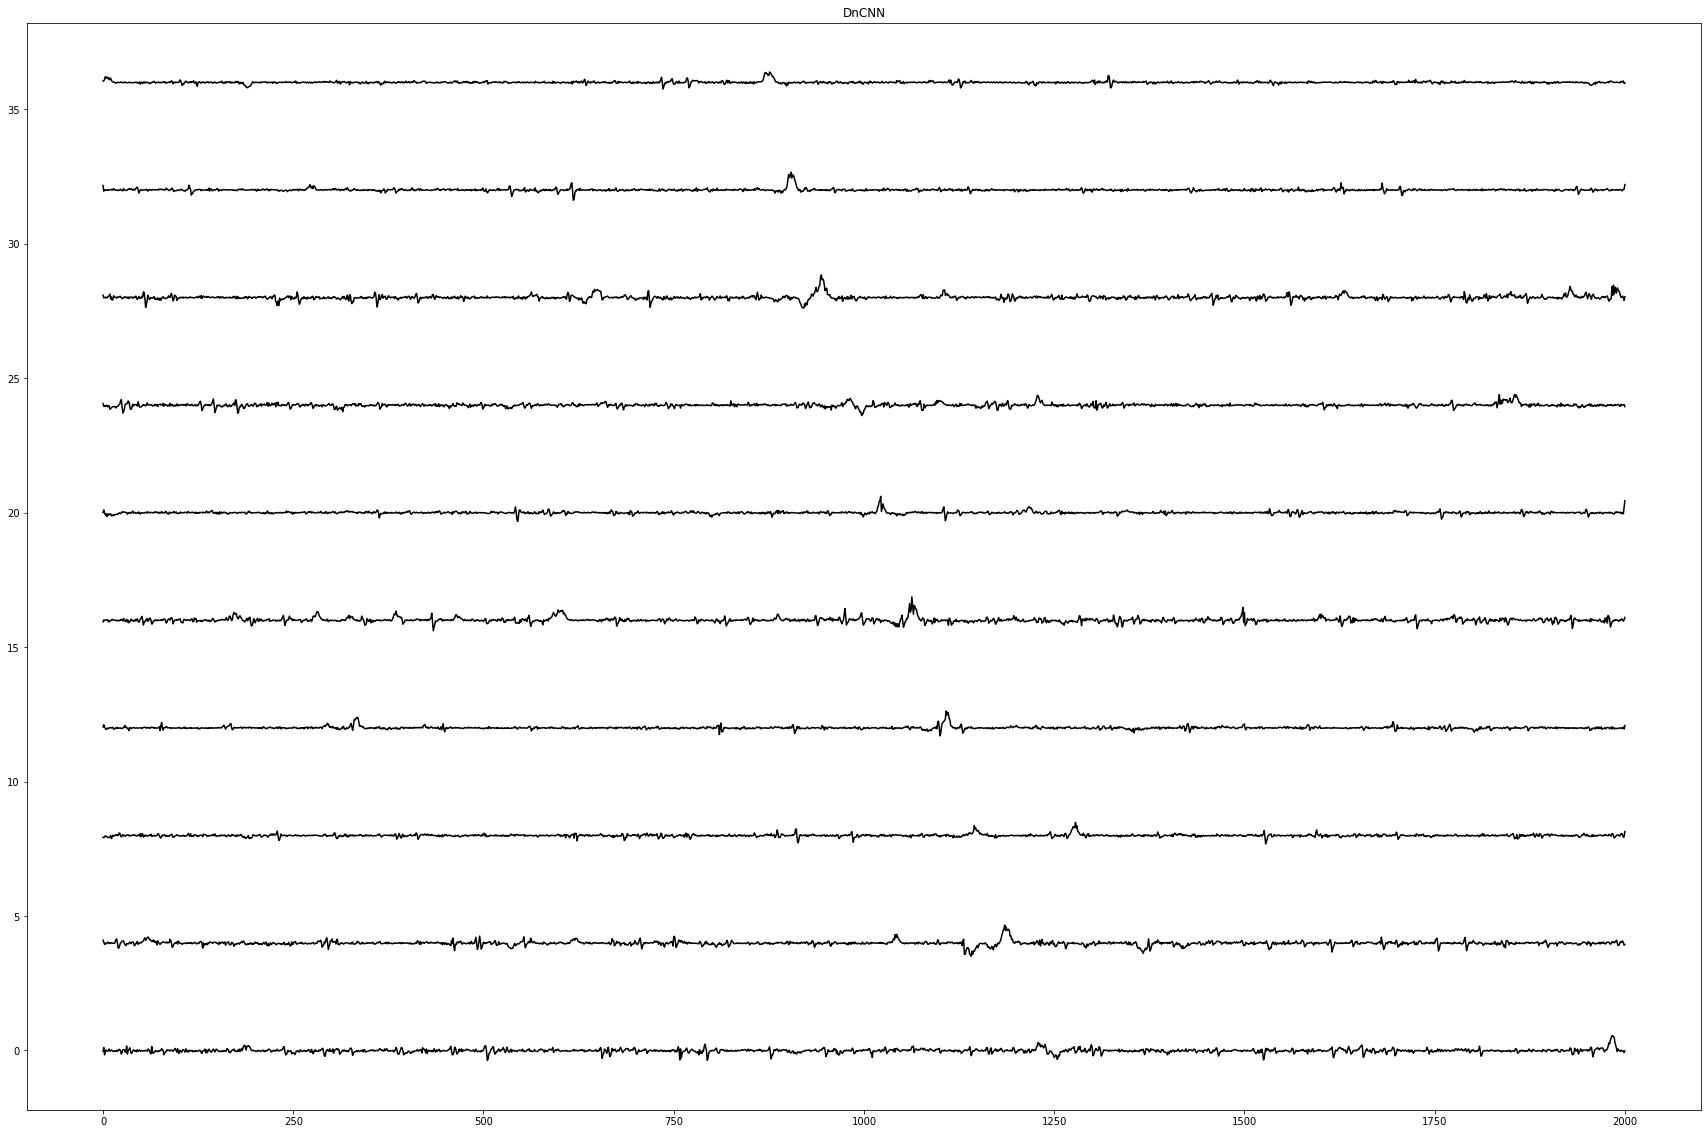

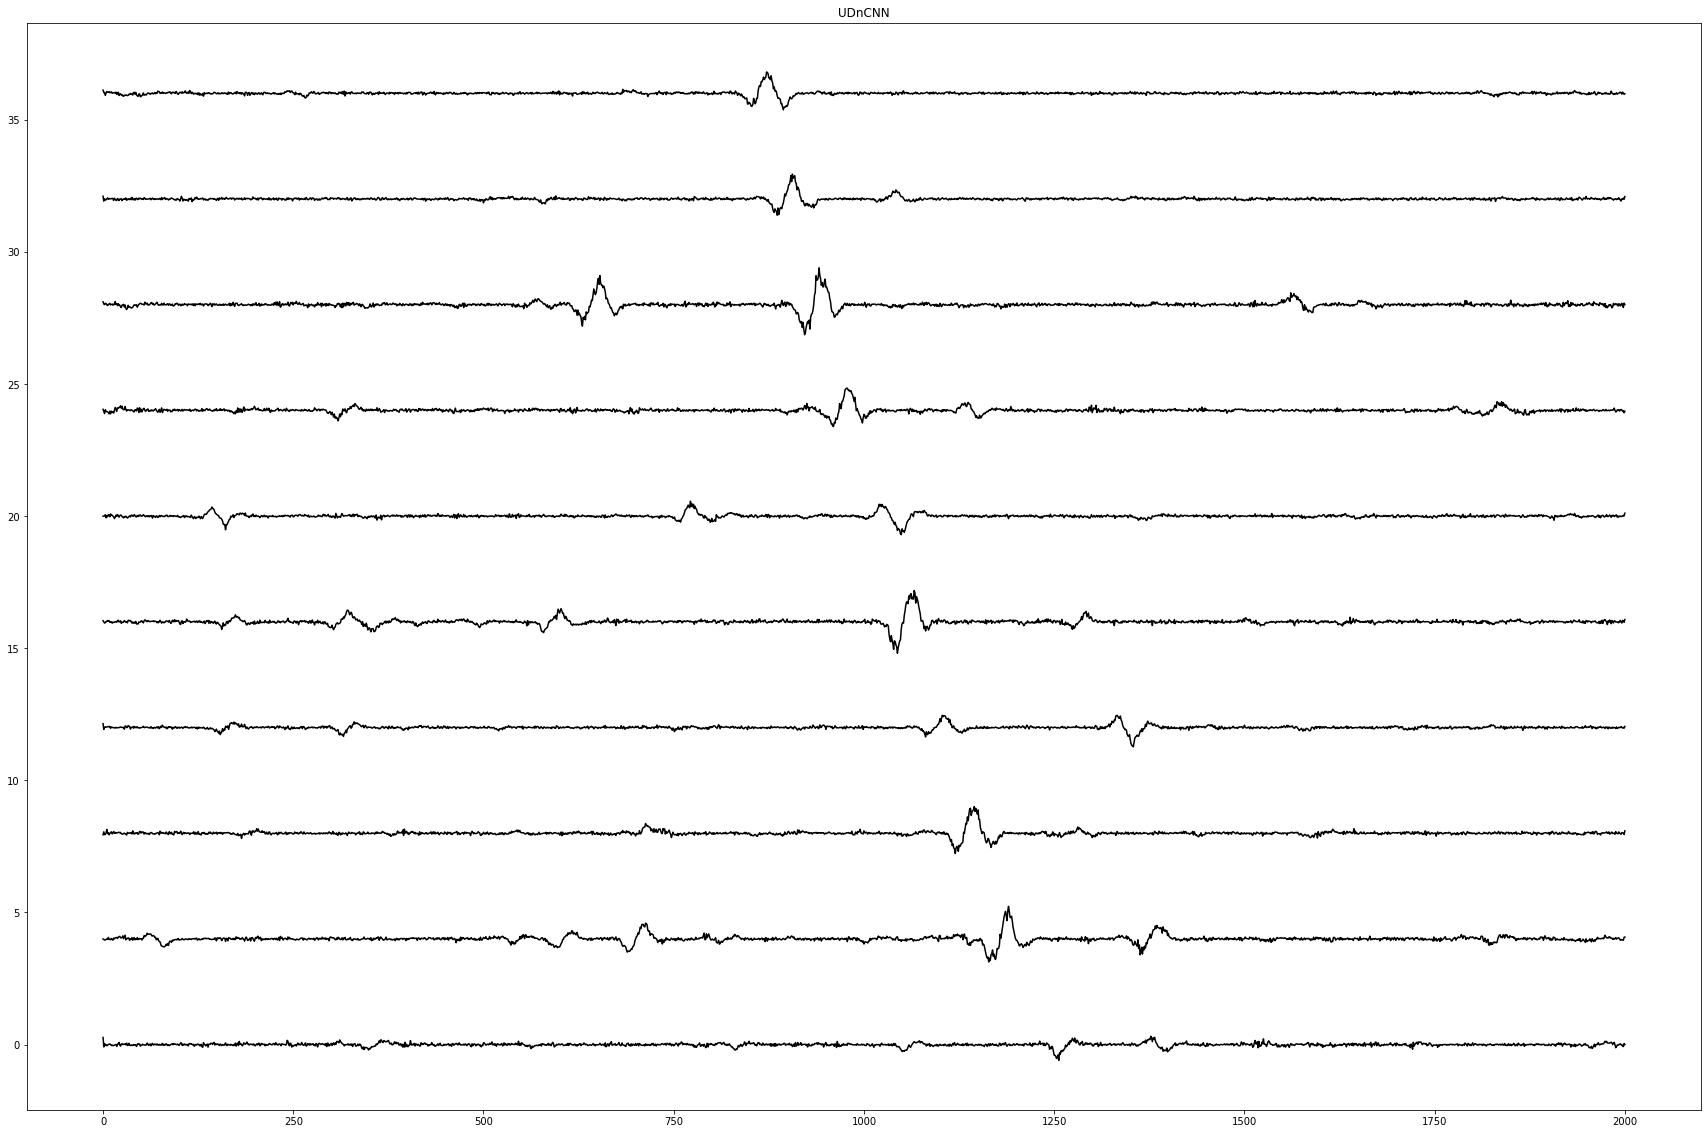

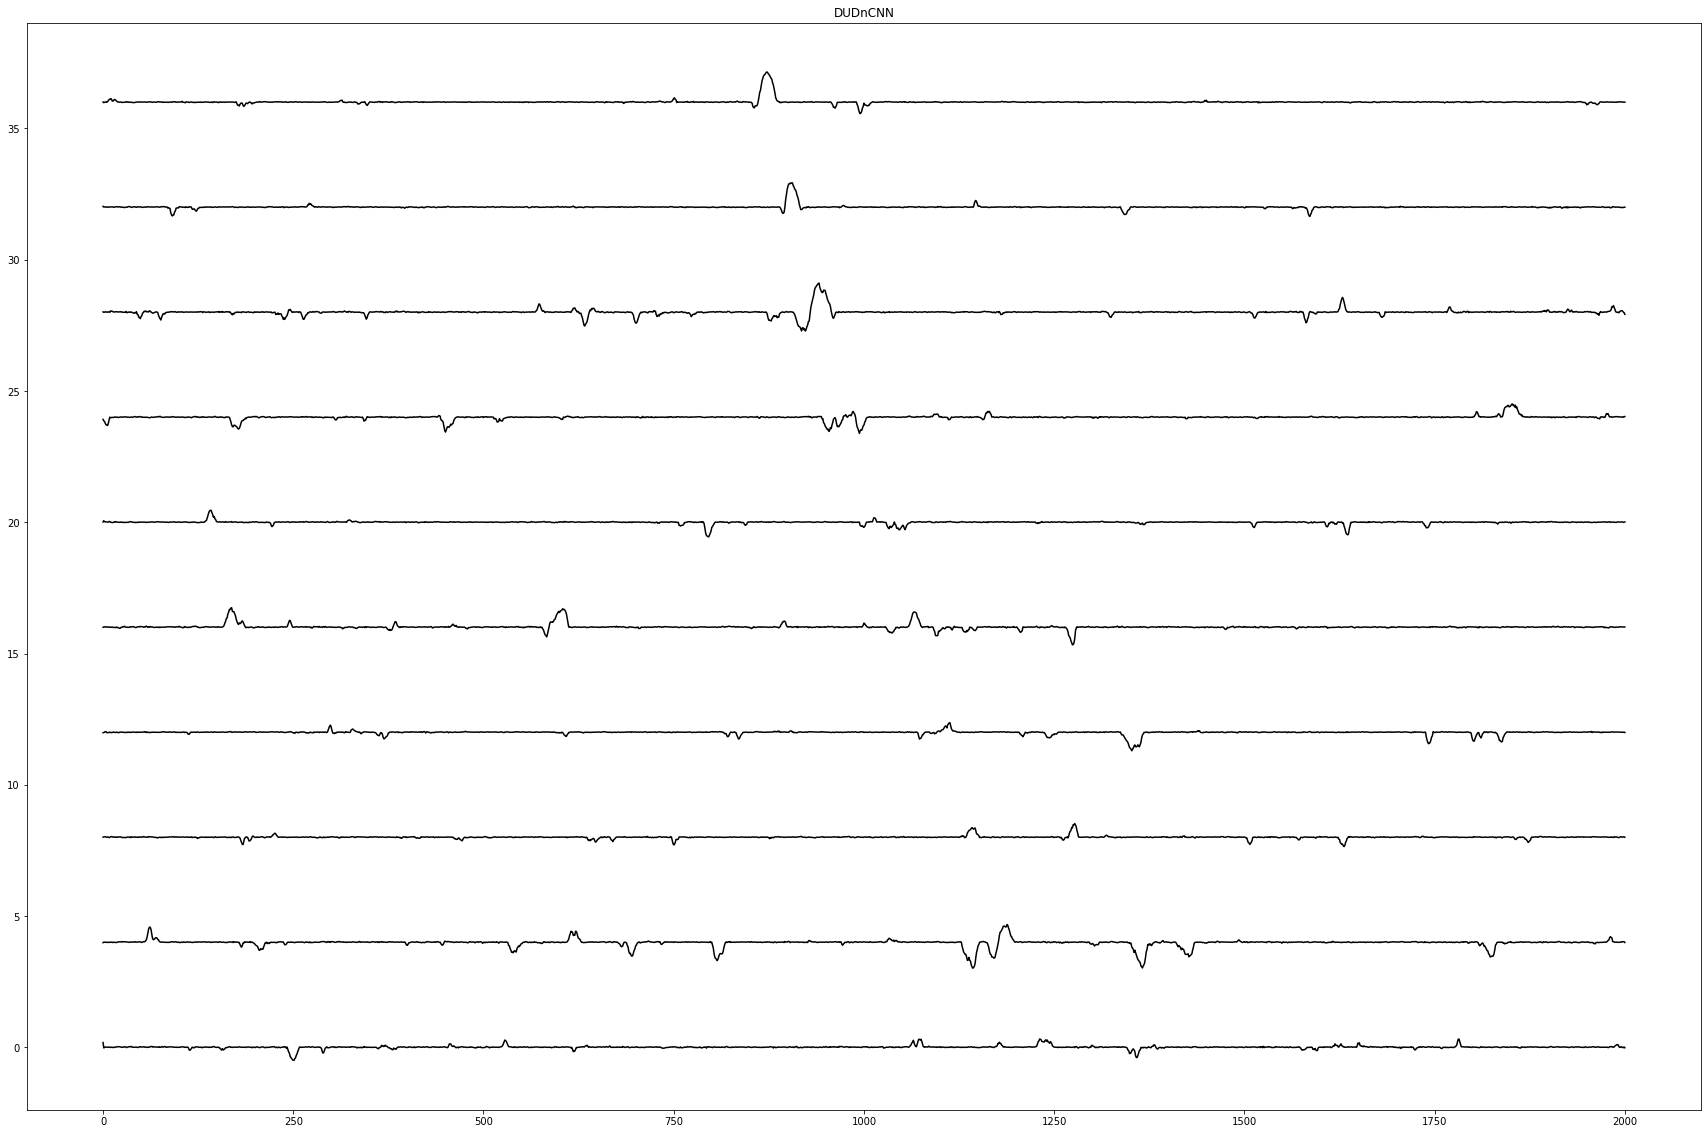

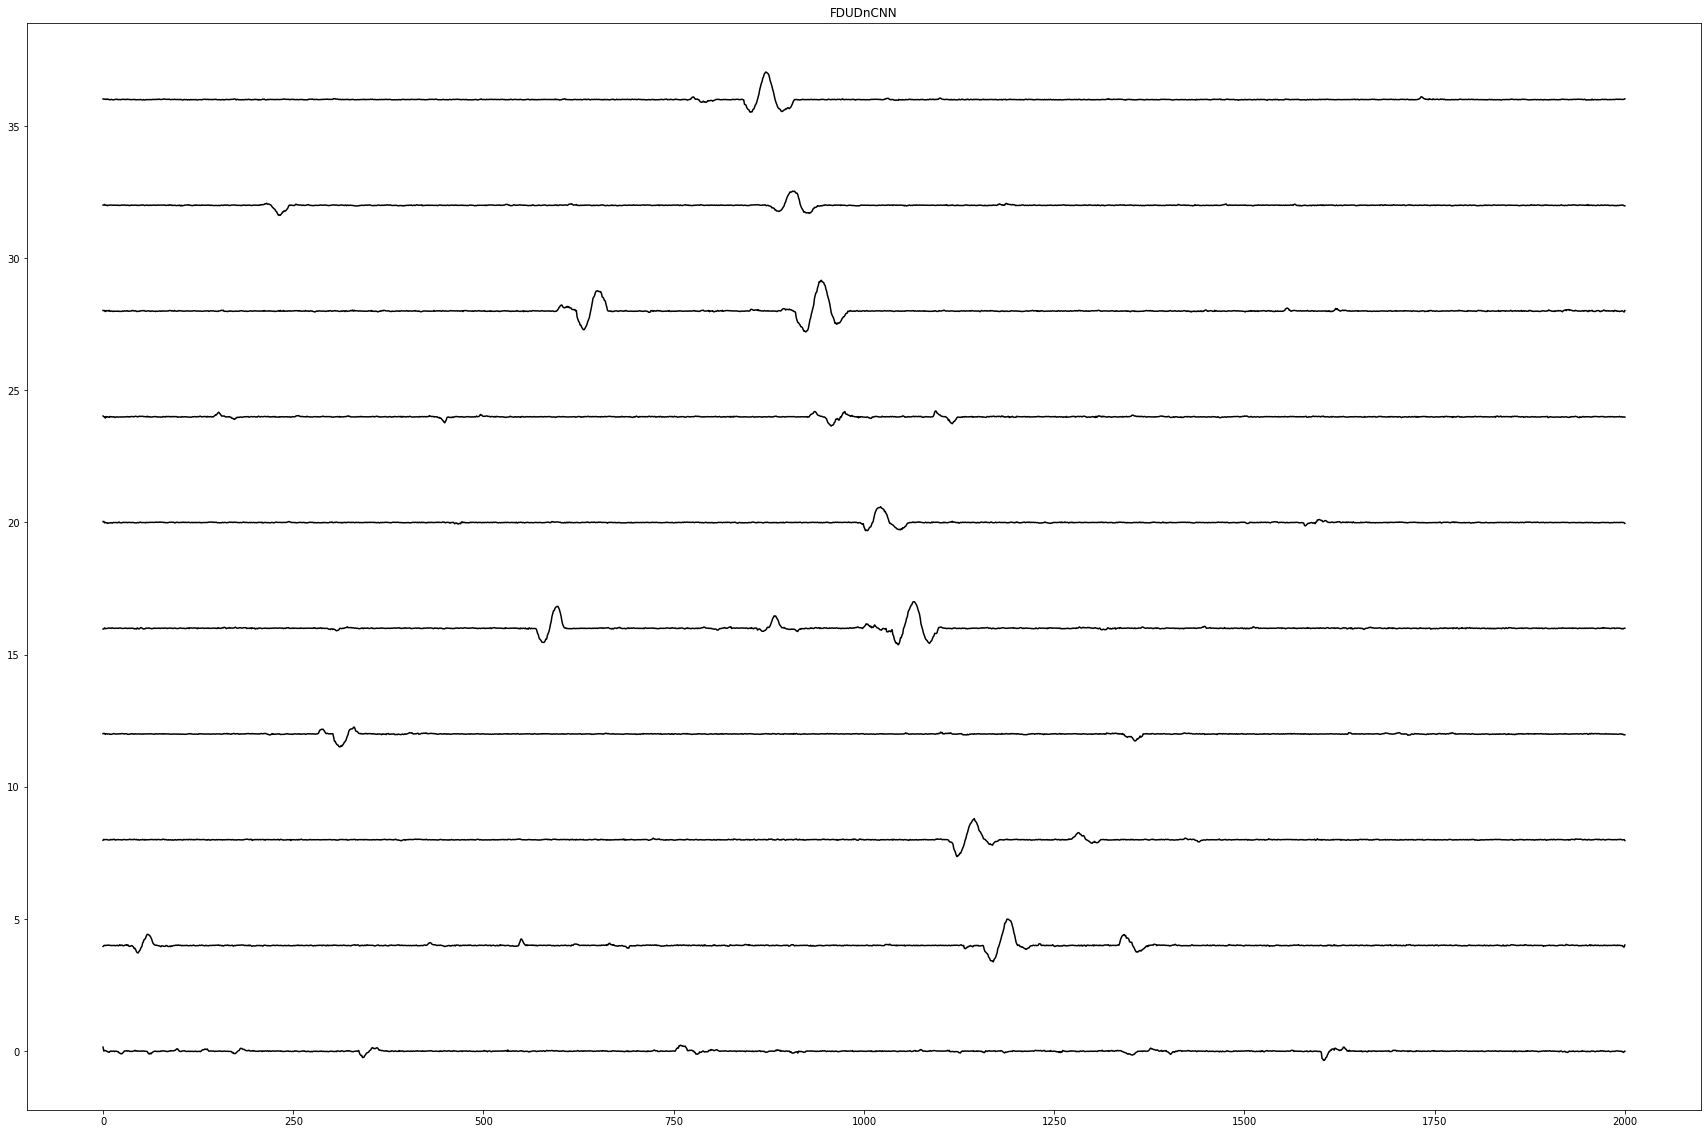

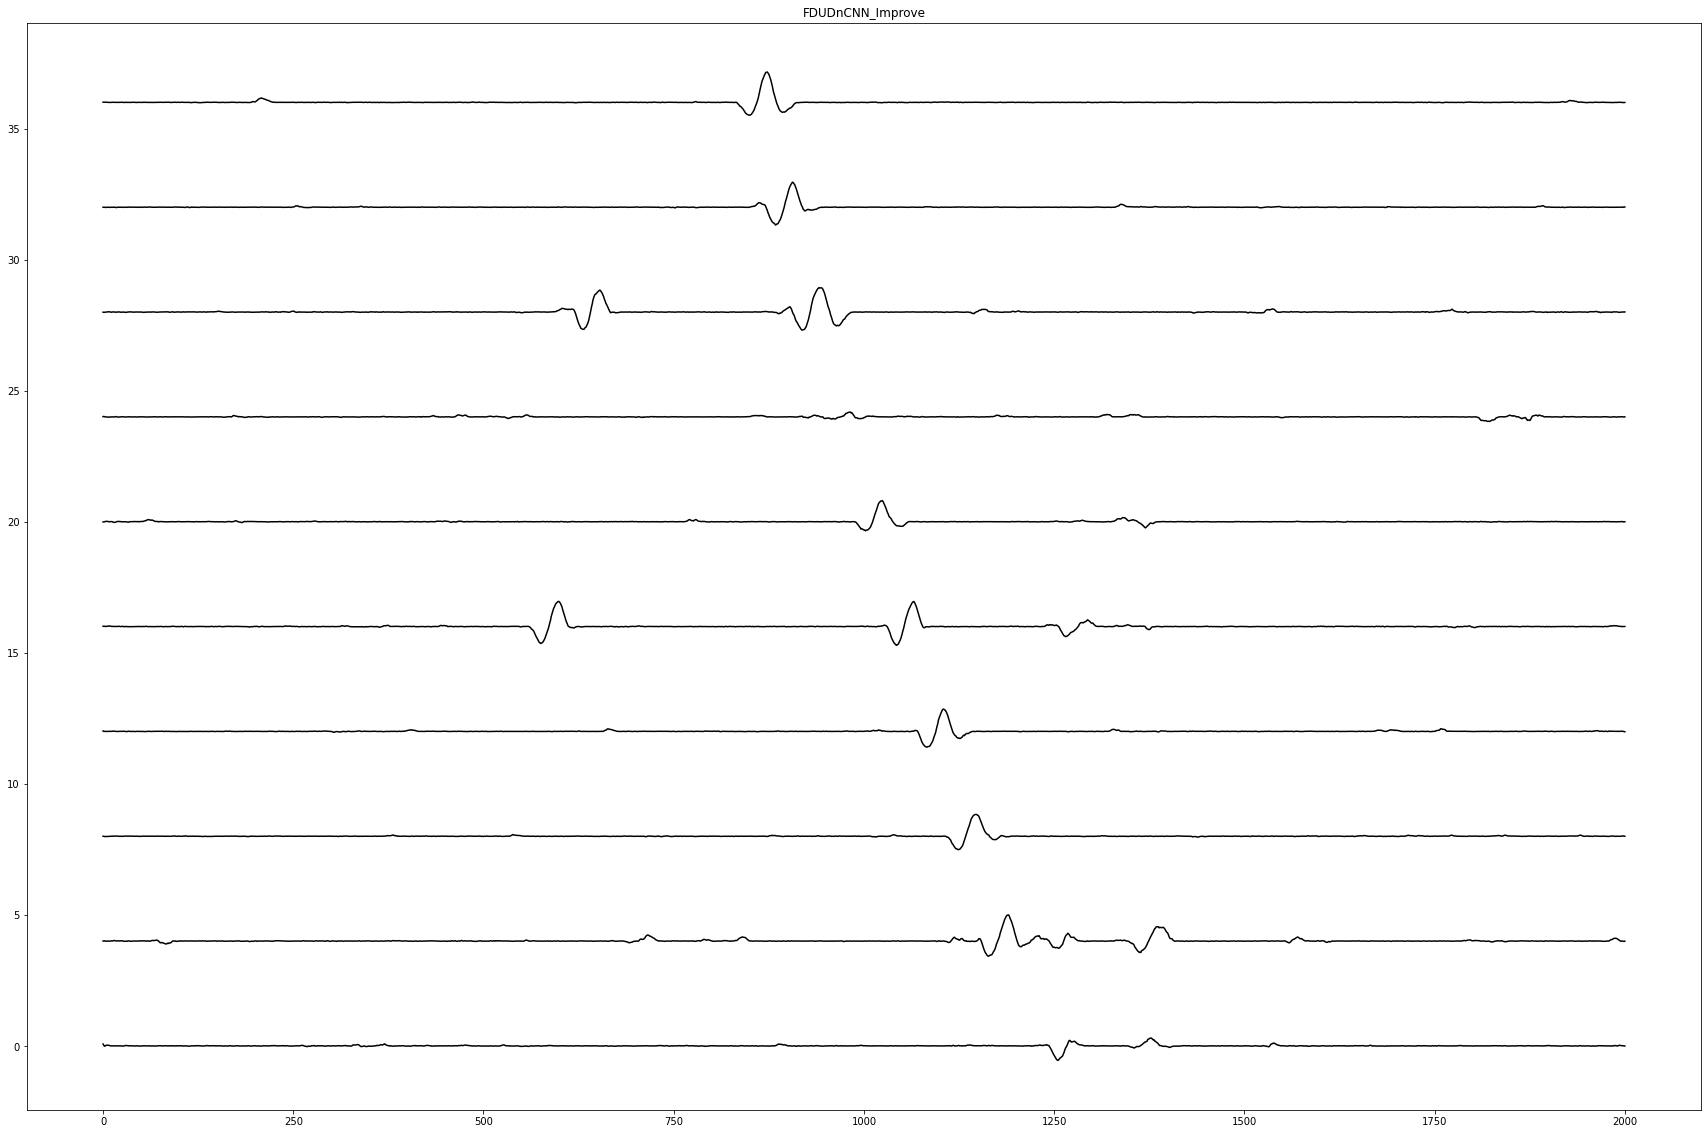

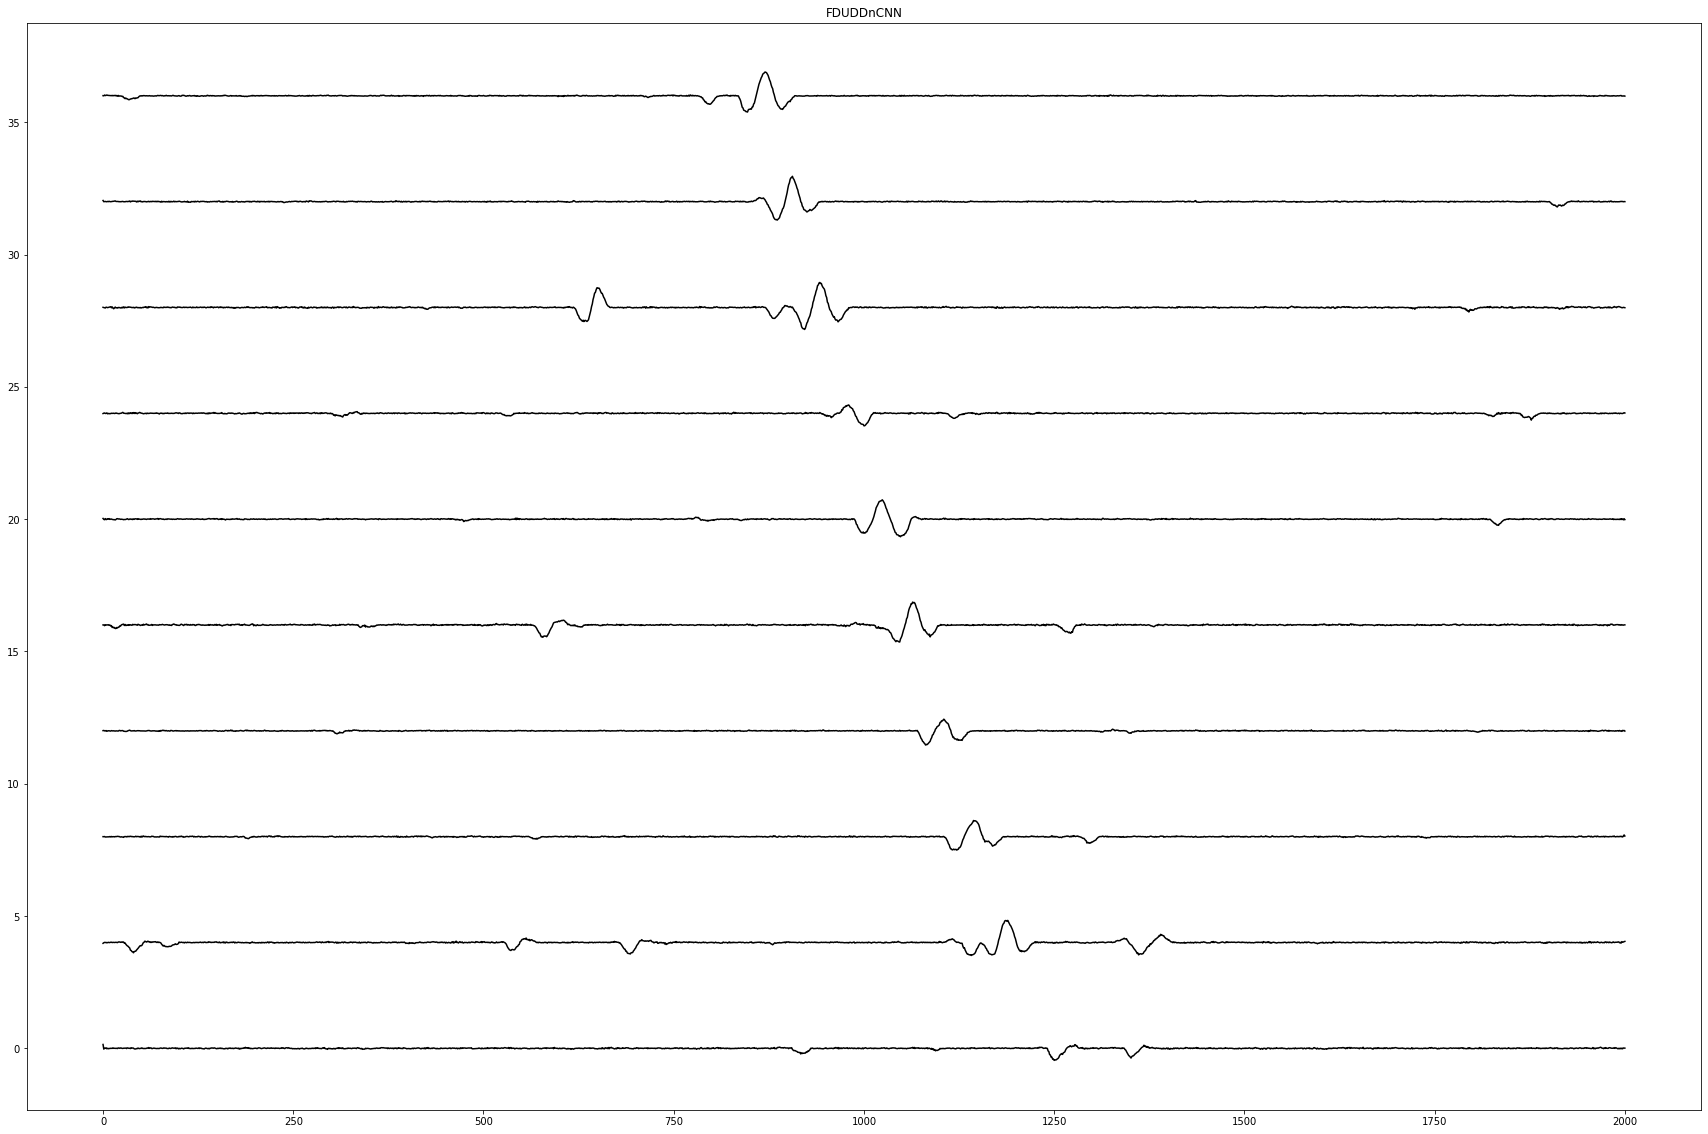

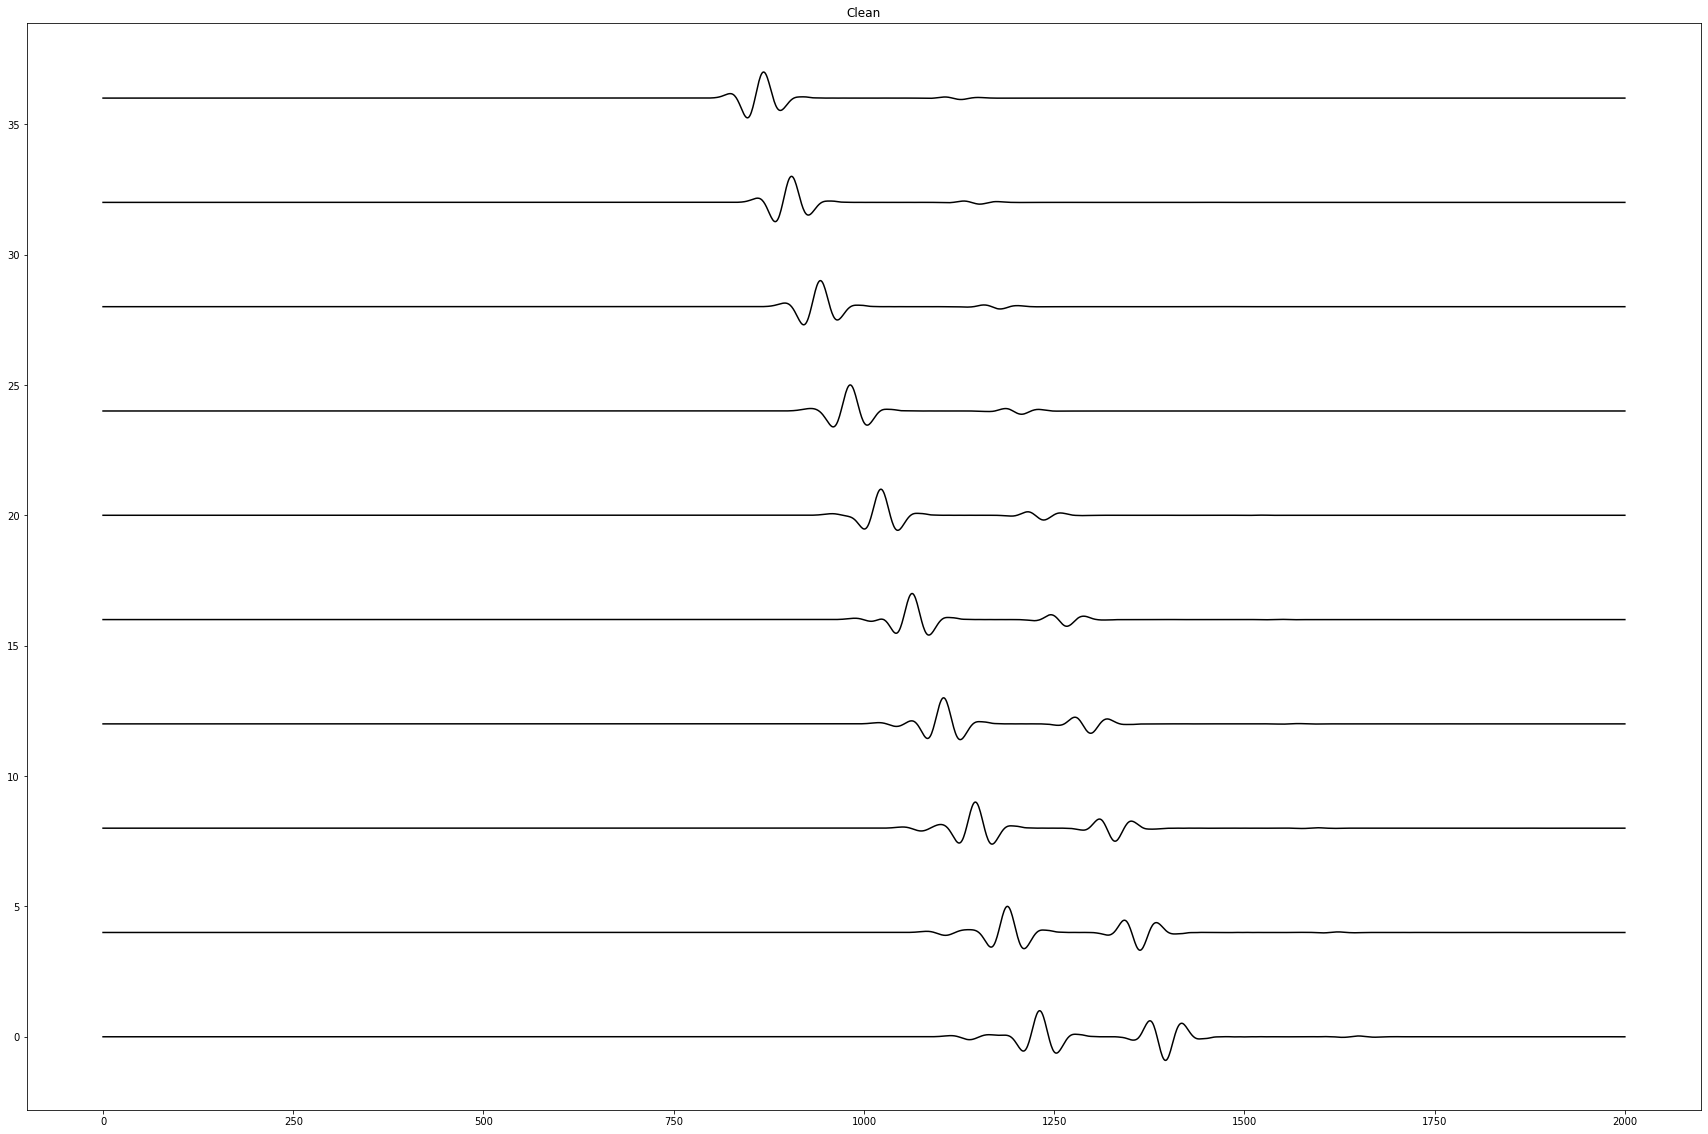

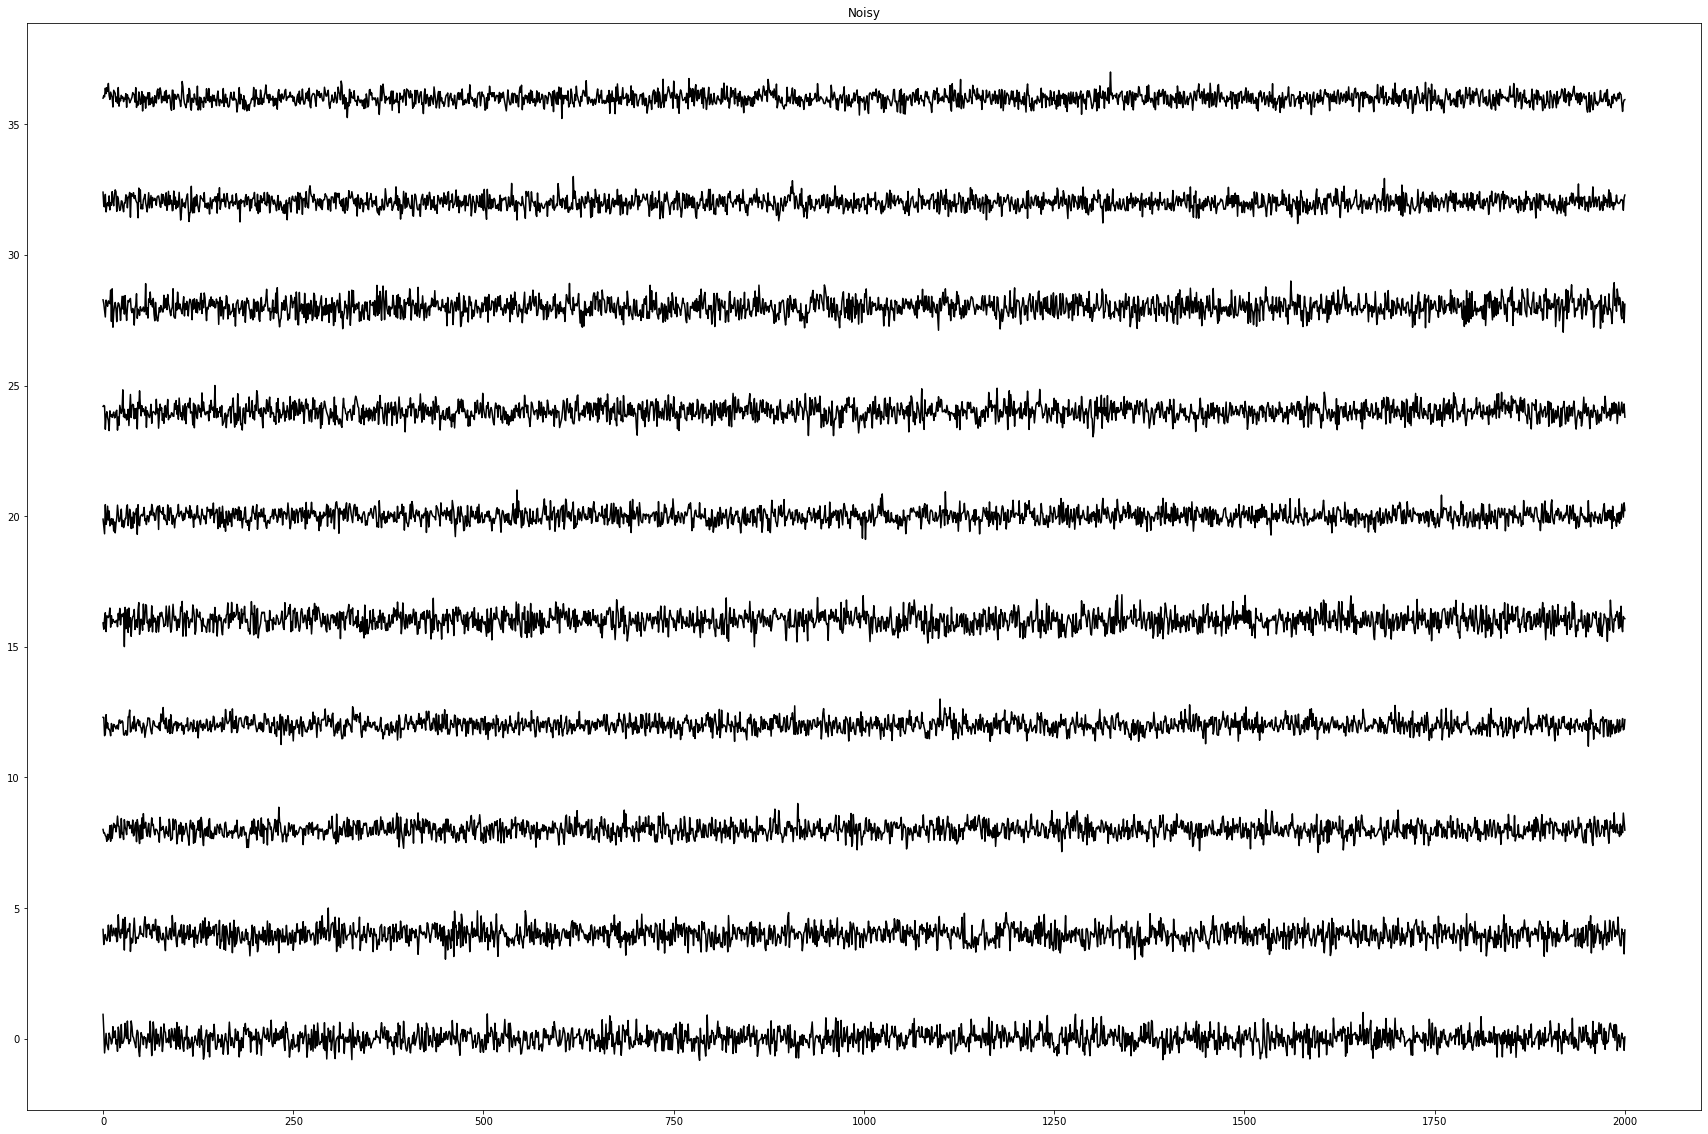

In [200]:
nets = [exp1.net, exp2.net, exp3.net, exp4.net,"","", exp7.net, exp8.net]
titles = ["DnCNN", "UDnCNN", "DUDnCNN", "FDUDnCNN", "DnCNN_DenseBlock" , "DenseNet", "FDUDnCNN_Improve", "FDUDDnCNN","Clean", "Noisy"]
for j in range(10):
    if(j == 4 or j == 5):
        continue
    fig = plt.figure(figsize = (30,20))
    ax  = fig.add_subplot(1,1,1)
    for i in range(10):
        item = i
        # item = random.randint(0, len(test_set)-1)
        noisy, clean = test_set[item]
        noisy = noisy.unsqueeze(0).to(device)
        clean = clean.unsqueeze(0).to(device)
        
        if(titles[j] == "Clean"):
            mysignalshow_10(clean[0], i, ax)
        elif(titles[j] == "Noisy"):
            mysignalshow_10(noisy[0], i, ax)
        else:  
            model = nets[j]
            model.eval()
            with torch.no_grad():
                y = model.forward(noisy)
            mysignalshow_10(y[0], i, ax)
       
        
    ax.set_title('{}'.format(titles[j]))
    os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\剖面', exist_ok=True)
    plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\剖面\{}.svg'.format(titles[j]))
    

### 8.2 画所有网络的结果图

1. DnCNN 
2. UDnCNN
3. DUDnCNN
4. FDUDnCNN
5. DnCNN_DenseBlock
6. DenseNet
7. FDUDDnCNN
8. FDUDnCNN_Imorove

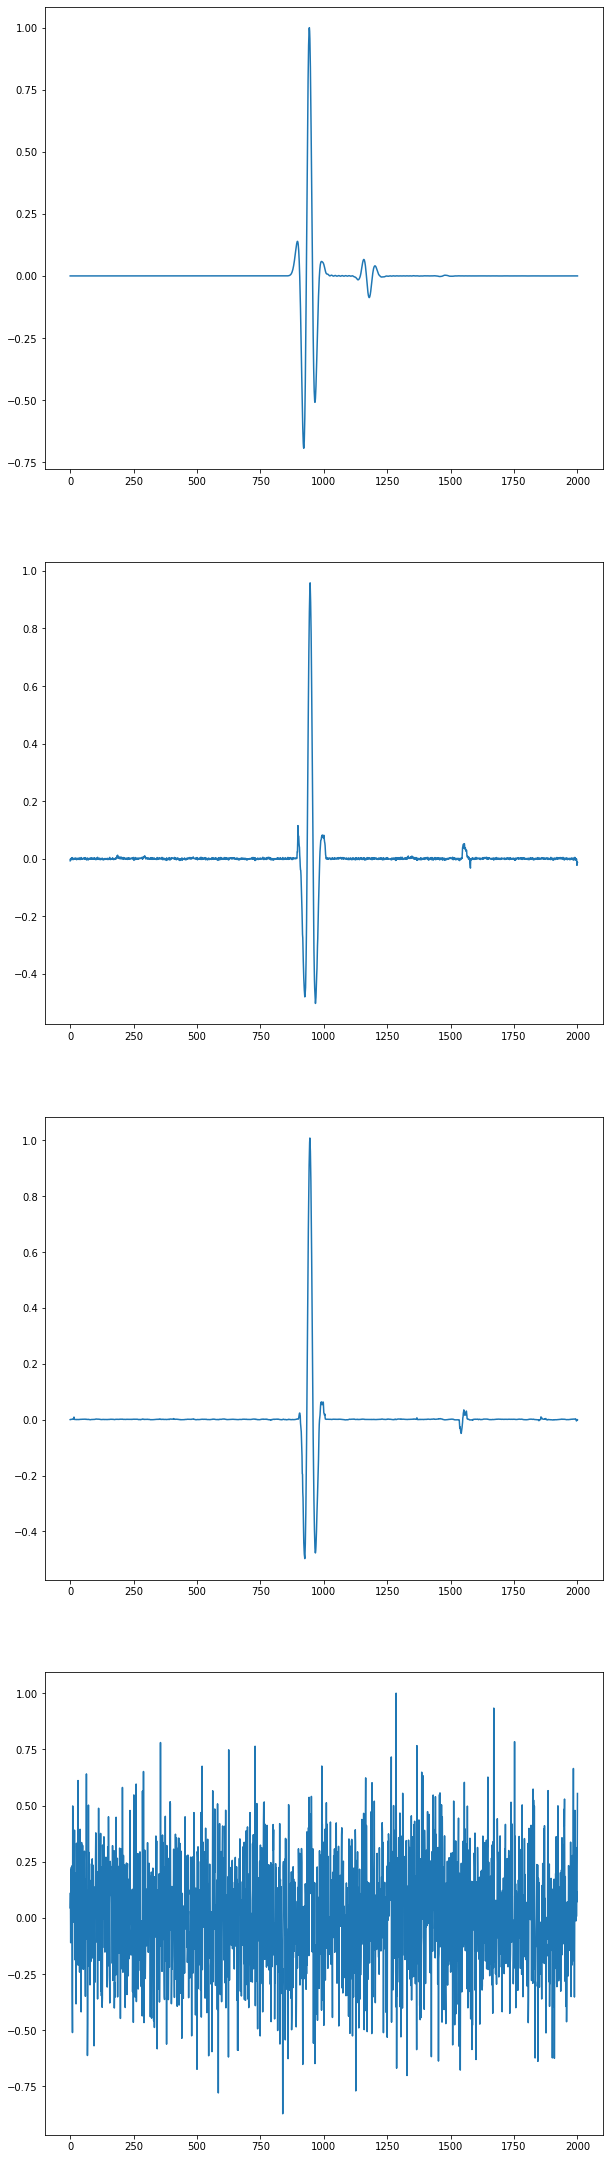

In [41]:
path = r"C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\实验数据保存\论文图像数据"
noisy,clean = test_set[7]
noisy = noisy.unsqueeze(0).to(device)
clean = clean.unsqueeze(0).to(device)


fig = plt.figure(figsize=(10, 80))

save_txt('Clean', clean[0].to('cpu').numpy()[0])
ax = fig.add_subplot(8, 1, 1)
ax.plot(clean[0].to('cpu').numpy()[0])


save_txt('Noisy', noisy[0].to('cpu').numpy()[0])
ax = fig.add_subplot(8, 1, 4)
ax.plot(noisy[0].to('cpu').numpy()[0])

# # 保存DnCNN
# model = exp1.net
# model.eval()
# with torch.no_grad():
#     y = model.forward(noisy)
# save_txt('DnCNN', y[0].to('cpu').numpy()[0])
# ax = fig.add_subplot(8, 1, 2)
# ax.plot(y[0].to('cpu').numpy()[0])


# # UDnCNN
# model = exp2.net
# model.eval()
# with torch.no_grad():
#     y = model.forward(noisy)
# save_txt('UDnCNN', y[0].to('cpu').numpy()[0])

# # DUDnCNN
# model = exp3.net
# model.eval()
# with torch.no_grad():
#     y = model.forward(noisy)
# save_txt('DUDnCNN', y[0].to('cpu').numpy()[0])
# # plt.plot(y[0].to('cpu').numpy()[0])

# # FDUDnCNN
# model = exp4.net
# model.eval()
# with torch.no_grad():
#     y = model.forward(noisy)
# save_txt('FDUDnCNN', y[0].to('cpu').numpy()[0])
# # plt.plot(y[0].to('cpu').numpy()[0])
# ax = fig.add_subplot(8, 1, 3)
# ax.plot(y[0].to('cpu').numpy()[0])

# # DenseNet
# model = exp6.net
# model.eval()
# with torch.no_grad():
#     y = model.forward(noisy)
# save_txt('DenseNet', y[0].to('cpu').numpy()[0])

# FDUDnCNN_Improve
model = exp8.net
model.eval()
with torch.no_grad():
    y = model.forward(noisy)
save_txt('FDUDnCNN_Improve', y[0].to('cpu').numpy()[0])
ax = fig.add_subplot(8, 1, 2)
ax.plot(y[0].to('cpu').numpy()[0])


# FDUDDnCNN
model = exp7.net
model.eval()
with torch.no_grad():
    y = model.forward(noisy)
save_txt('FDUDDnCNN', y[0].to('cpu').numpy()[0])
ax = fig.add_subplot(8, 1, 3)
ax.plot(y[0].to('cpu').numpy()[0])


In [684]:
# for i in range(len(test_set)):
#     noisy, clean = test_set[i]
#     noisy = noisy.unsqueeze(0).to(device)
#     clean = clean.unsqueeze(0).to(device)
#     fig = plt.figure(figsize = (30,20))
#     ax1  = fig.add_subplot(4,1,1)
#     ax2  = fig.add_subplot(4,1,2)
#     ax3  = fig.add_subplot(4,1,3)
#     ax4  = fig.add_subplot(4,1,4)
# #     fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(20,10))
#     # 画一个clean
#     mysignalshow(clean[0], ax1)
#     ax1.set_title('{}'.format("clean"))
    
#     # 画一个noisy
#     mysignalshow(noisy[0], ax2)
#     ax2.set_title('{}'.format("noisy"))
    
#     # 画一个DUDnCNN
#     model = exp3.net
#     model.eval()
#     with torch.no_grad():
#         y = model.forward(noisy)
#     mysignalshow(y[0], ax3)
#     ax3.set_title('{}'.format("DUDnCNN"))
    
#     # 画一个CBDNet
#     model = exp4.net
#     model.eval()
#     with torch.no_grad():
#         y = model.forward(noisy)
#     mysignalshow(y[0], ax4)
#     ax4.set_title('{}'.format("CBDNet"))
    
    
#     os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\论文', exist_ok=True)
#     plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\论文\{}.svg'.format(i))
#     plt.close(fig) 

## 9.测试训练

### 使用真实信号给网络进行测试

读取真实信号数据

In [367]:
path = r"C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\dataset"
filenames = []
# 读取dataset文件夹下的干净信号txt
filenames = os.listdir(os.path.join(path,"clean_signal","真实信号txt"))
filenames.sort(key = lambda x: int(x[0:-4]))
real_signal = []
for filename in filenames:
    real_signal.append(np.loadtxt(os.path.join(path,"clean_signal","真实信号txt", filename)))

In [368]:
# 把真实信号放进去（长度的为6001）， 然后获取这个信号中间特征和结果，
# 然后保存到C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\实验数据保存\论文图像数据

# 参数说明:
# real_or_analog ： 该函数同时负责真实信号和模拟信号，因此 1 代表真实信号， 0 代表模拟信号
def put1dToModelAndPlot(model, real_signal, ax , num , name, real_or_analog , saveOriginSignal = 0):
    len = 0
    if real_or_analog == 1:
        len = 3
    else:
        len = 1
    x = maxabs_scale(real_signal, axis=0)
    y = np.array([])
    feature = np.array([])
    if(saveOriginSignal == 1):
        y = x
        save_txt("{}_Real_signal {}".format(name, num+1), y)   # 保存数据  
        temp = [item+4*i for item in y]
        ax.plot(temp,color="black")
        return y
    for j in range(len):
        if(j == 0):
            x1 = x[:2001]
        elif(j == 1):
            x1 = x[2001:4002]
        else:
            x1 = x[4000:6001]
        x1 = torch.Tensor(x1).to(device)   
        x1 = x1.unsqueeze(0)
        x1 = x1.unsqueeze(0)
        y1 = model.forward(x1)
        y1 = y1.to('cpu')[0][0]
        y1 = y1.detach().numpy()
        y1 = np.array(y1)
        y = np.concatenate((y, y1))
        feature = np.concatenate((feature, np.sum(model.features[5].cpu().detach().numpy(), axis=1)[0]))
        
        
        
    save_txt("{}_Real_signal {}".format(name, num+1), y)   # 保存数据  
    save_txt("{}_Conv_Feature {}".format(name, num+1), feature)   # 保存数据  
    temp = [item+4*i for item in y]    
    ax.plot(temp,color="black")
    return y

In [369]:
path = r"C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\真实信号结果"
profile_path = r"C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\实验数据保存\论文图像数据\剖面"
analog_profile_path = r"C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\实验数据保存\论文图像数据\剖面\模拟信号剖面"
os.makedirs(path, exist_ok=True)
os.makedirs(profile_path, exist_ok=True)
os.makedirs(analog_profile_path, exist_ok=True)
real_signal_num = 10
analog_signal_num = 10



# 画出clean 信号 
profile = []
fig1 = plt.figure(figsize = (30,20))
ax1 = fig1.add_subplot(1,1,1)
for i in range(real_signal_num):
    item = real_signal[i]
    profile.append(put1dToModelAndPlot("", item, ax1, i, "Clean",1, 1))
fig1.suptitle("Clean", fontsize = 30)
plt.savefig(os.path.join(path, "Clean.svg"))
plt.close()
print(profile)
np.savetxt(os.path.join(profile_path, "Clean.txt"), np.array(profile))

# FDUDDnCNN 信号 
profile = []
fig1 = plt.figure(figsize = (30,20))
ax1 = fig1.add_subplot(1,1,1)
for i in range(real_signal_num):
    item = real_signal[i]
    profile.append(put1dToModelAndPlot(exp7.net, item, ax1, i, "FDUDDnCNN", 1))
fig1.suptitle("FDUDDnCNN", fontsize = 30)
plt.savefig(os.path.join(path, "FDUDDnCNN.svg"))
plt.close()
np.savetxt(os.path.join(profile_path, "FDUDDnCNN.txt"), np.array(profile))



# FDUDnCNN_Improve 信号 
profile = []
fig1 = plt.figure(figsize = (30,20))
ax1 = fig1.add_subplot(1,1,1)
for i in range(real_signal_num):
    item = real_signal[i]
    profile.append(put1dToModelAndPlot(exp8.net, item, ax1, i, "FDUDnCNN_Improve", 1))
fig1.suptitle("FDUDnCNN_Improve", fontsize = 30)
plt.savefig(os.path.join(path, "FDUDnCNN_Improve.svg"))
plt.close()
np.savetxt(os.path.join(profile_path, "FDUDnCNN_Improve.txt"), np.array(profile))


#----------------------------------------------------以下：模拟信号剖面-----------------------------------------------------------------------


# 画出clean 信号 
profile = []
fig1 = plt.figure(figsize = (30,20))
ax1 = fig1.add_subplot(1,1,1)
for i in range(analog_signal_num):
    item = test_set[i][1][0].detach().numpy()
    profile.append(put1dToModelAndPlot("", item, ax1, i, "Clean", 0, 1))
fig1.suptitle("Clean", fontsize = 30)
plt.savefig(os.path.join(path, "Clean.svg"))
plt.close()
print(profile)
np.savetxt(os.path.join(analog_profile_path, "Clean.txt"), np.array(profile))

# 画noisy 信号 
profile = []
fig1 = plt.figure(figsize = (30,20))
ax1 = fig1.add_subplot(1,1,1)
for i in range(analog_signal_num):
    item = test_set[i][0][0].detach().numpy()
    profile.append(put1dToModelAndPlot("", item, ax1, i, "Noisy", 0, 1))
fig1.suptitle("Noisy", fontsize = 30)
plt.savefig(os.path.join(path, "Noisy.svg"))
plt.close()
print(profile)
np.savetxt(os.path.join(analog_profile_path, "Noisy.txt"), np.array(profile))

# FDUDDnCNN 信号 
profile = []
fig1 = plt.figure(figsize = (30,20))
ax1 = fig1.add_subplot(1,1,1)
for i in range(analog_signal_num):
    item = test_set[i][0][0].detach().numpy()
    profile.append(put1dToModelAndPlot(exp7.net, item, ax1, i, "FDUDDnCNN", 0))
fig1.suptitle("FDUDDnCNN", fontsize = 30)
plt.savefig(os.path.join(path, "FDUDDnCNN.svg"))
plt.close()
np.savetxt(os.path.join(analog_profile_path, "FDUDDnCNN.txt"), np.array(profile))

# FDUDnCNN_Improve 信号 
profile = []
fig1 = plt.figure(figsize = (30,20))
ax1 = fig1.add_subplot(1,1,1)
for i in range(real_signal_num):
    item = test_set[i][0][0].detach().numpy()
    profile.append(put1dToModelAndPlot(exp8.net, item, ax1, i, "FDUDnCNN_Improve", 0))
fig1.suptitle("FDUDnCNN_Improve", fontsize = 30)
plt.savefig(os.path.join(path, "FDUDnCNN_Improve.svg"))
plt.close()
np.savetxt(os.path.join(analog_profile_path, "FDUDnCNN_Improve.txt"), np.array(profile))



[array([ 0.12711864,  0.04237288,  0.05508475, ..., -0.27966102,
       -0.40677966, -0.30508475]), array([ 0.04812834,  0.04812834, -0.1657754 , ..., -0.52406417,
       -0.56149733, -0.74331551]), array([ 0.26666667,  0.06666667,  0.13939394, ...,  0.00606061,
       -0.02424242,  0.12727273]), array([ 0.19473684, -0.10526316,  0.15263158, ...,  0.33684211,
        0.11578947,  0.4       ]), array([-0.12544803, -0.06451613, -0.17204301, ..., -0.22939068,
       -0.23297491, -0.3046595 ]), array([0.16969697, 0.09696969, 0.2969697 , ..., 0.46666667, 0.24242424,
       0.24848485]), array([-0.00568182, -0.15909091,  0.00568182, ...,  0.22159091,
        0.00568182,  0.3125    ]), array([-0.00694444,  0.04166667, -0.15972222, ..., -0.04166667,
        0.15972222,  0.04166667]), array([0.07692308, 0.1025641 , 0.26495726, ..., 0.25641026, 0.4017094 ,
       0.23931624]), array([ 0.13924051, -0.23417722,  0.10126581, ...,  0.14556962,
       -0.10759494,  0.43670886])]
[array([ 0.0000000e+0

## 获取噪音成分

In [370]:
noisy_signal = np.loadtxt(os.path.join(analog_profile_path, "Noisy.txt"))
FDUDDnCNN_signal = np.loadtxt(os.path.join(analog_profile_path, "FDUDDnCNN.txt"))
residual_signal = []

for num in range(len(noisy_signal)):
    temp = noisy_signal[num] - FDUDDnCNN_signal[num]
    residual_signal.append(temp)

np.savetxt(os.path.join(analog_profile_path, "Residual.txt"), np.array(residual_signal))


In [231]:
# 两个残差的差值
Residual_1 = np.loadtxt(os.path.join(profile_path, "模拟信号剖面+1", "Residual.txt"))
Residual_2 = np.loadtxt(os.path.join(profile_path, "模拟信号剖面-1", "Residual.txt"))

residual_signal = []
for num in range(len(Residual_1)):
    temp = Residual_1[num] - Residual_2[num]
    residual_signal.append(temp)

    
np.savetxt(os.path.join(profile_path, "Residual_minus.txt"), np.array(residual_signal))



## 10. 看下数据集

In [ ]:
train_set[1]
for i in range(len(train_set)):
    plt.clf()
    plt.plot(train_set[i][1][0])
    plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\信号\{}.svg'.format(i))

# GAN_compete

In [21]:
def plot(exp, fig, axes, noisy, clean, visu_rate=2):
#     if(exp.epoch != 200):
#         return 
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net1(noisy[None].to(net1.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()

    mysignalshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy signal')
    
    mysignalshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised signal')
    
    mysignalshow(clean, ax=axes[0][2])
    axes[0][2].set_title('Clean signal')
    
    axes[1][0].plot([exp.history1[k]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history1[k]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

In [22]:
# 定义一个管理网络中参数的管理器
class StatsManager(object):
    def __init__(self):
        self.init()
        
    def __repr__(self):
        return self.__class__.__name__
    
    def init(self):
        self.running_loss=0
        self.number_update=0
        
    def accumulate(self, loss, vinput=None, voutput=None, vtarget=None):
        self.running_loss+=loss
        self.number_update+=1
    
    def summarize(self):
        return self.running_loss/self.number_update

In [23]:
class DnCNN(NeuralNetwork):
    def __init__(self, D , C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        # 用于保留最后一个batch中所有的特征
        self.features = []
        
        # 开始搭建卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(1, C, 3, padding = 1))
        self.conv.extend([nn.Conv1d(C, C, 3, padding = 1) for _ in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding = 1))
        
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv)):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # 设置bn层
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C) for _ in range(D)])
        for i in range(len(self.bn)):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
            
    def forward(self, vinput):
        self.features.clear()
        D = self.D
        h = F.leaky_relu(self.conv[0](vinput))
        self.features.append(h)
        for i in range(D):
            h = F.leaky_relu(self.bn[i](self.conv[i+1](h)))
            self.features.append(h)
        voutput = self.conv[D+1](h) + vinput
        return voutput
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)

In [66]:
class Disriminator(NeuralNetwork):
    def __init__(self, C=2001):
        super(Disriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2001, C),
            nn.BatchNorm1d(C),
            nn.LeakyReLU(0.2),
            
            nn.Linear(C, C),
            nn.BatchNorm1d(C),
            nn.LeakyReLU(0.2),
            
            nn.Linear(C, 1),
            nn.Sigmoid(),
        )

    def forward(self, vinput):
        return self.fc(vinput)
    
    def criterion(self, voutput, vtarget): # 这个不用
        pass

In [126]:
# 定义一个训练的类
class Experiment_Compete(object):
    def __init__(self, net1, net2, Dnet , train_set, val_set, optimizer1, optimizer2, optimizer3, stats_manager1, stats_manager2, 
                output_dir = None, batch_size = 16):
    
        # Define data Loaders
        # shuffle=True 在每个新的epoch里面会重新打乱形成新的batch
        # drop_last=True 当样本数量被分割成多个batch的时候，如果还有多的数据（少于batchsize），那么这些样本会被扔掉
        # pin_memory=True 让每个batch形成的张量能更快进入到cuda中
        self.train_loader = td.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
        self.val_loader = td.DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        # Define history
        self.history1 = []
        self.history2 = []

        # Define checkpoint paths
        if output_dir is None:
            output_dir = "Denoising_{}".format(time.time())
        os.makedirs(output_dir, exist_ok=True)
        checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        config_path = os.path.join(output_dir, "config.txt")

        # 将全局变量全部转化成字典形式
        maps = {k:v for k, v in locals().items() if k != 'self'}
        self.__dict__.update(maps)

        # 存储checkpoint或者继续加载模型
        if os.path.isfile(self.config_path):
            with open(config_path, 'r') as f:

                if (f.read()[:-1] != repr(self)):
                    raise ValueError(
                            "Cannot create this experiment: "
                            "I found a checkpoint conflicting with the current setting.")
                else:
                    self.load()
        else:
            self.save()
    
    # 获取当前的epoch
    @property
    def epoch(self):
        return len(self.history1)
    
    @property
    def epoch1(self):
        return len(self.history1)
    
    @property
    def epoch2(self):
        return len(self.history2)
    
    # 获取当前的网络的配置，用字典返回
    def setting(self):
        return {'Net1': self.net1,
                'Net2': self.net2,
                'DNet': self.Dnet,
                'TrainSet': self.train_set,
                'ValSet': self.val_set,
                'Optimizer1': self.optimizer1,
                'Optimizer2': self.optimizer2,
                'Optimizer3': self.optimizer3,
                'StatsManager1': self.stats_manager1,
                'StatsManager2': self.stats_manager2,
                'BatchSize': self.batch_size}   
    
    # 重写repr内置函数，用字符串的形式返回当前网络的配置
    def __repr__(self):
        string = ''
        for k, v in self.setting().items():
            if(k == 'TrainSet' or k == 'ValSet'):
                v = "Size is " + str(len(v))
            string += '{} : {} \n'.format(k, v)
        return string
    
    # 返回当前网络训练的状态，用字典的形式
    def state_dict(self):
        return {'Net1': self.net1.state_dict(),
                'Net2': self.net2.state_dict(),
                'DNet':self.Dnet.state_dict(),
                'Optimizer1': self.optimizer1.state_dict(),
                'Optimizer2': self.optimizer2.state_dict(),
                'Optimizer3': self.optimizer3.state_dict(),
                'History1': self.history1,
                'History2': self.history2}
        
        
    # 将网络模型(重写的repr返回值)保存在config_path中，同时将网络的state_dict（参数什么的）保存到checkpoint_path
    def save(self):
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)
    
    
    # 读取检查点，进行装载
    def load(self):
        checkpoint = torch.load(self.checkpoint_path, map_location=self.net1.device)
        self.net1.load_state_dict(checkpoint['Net1'])
        self.net2.load_state_dict(checkpoint['Net2'])
        self.Dnet.load_state_dict(checkpoint['DNet'])
        self.optimizer1.load_state_dict(checkpoint['Optimizer1'])
        self.optimizer2.load_state_dict(checkpoint['Optimizer2'])
        self.optimizer3.load_state_dict(checkpoint['Optimizer3'])
        self.history1 = checkpoint['History1']
        self.history2 = checkpoint['History2']
        del checkpoint
        
        
    def run(self, num_epochs, plot=None):
        # 设置网络的状态是train状态(mode=True)，而不是eval状态(mode=False)，这只对某些特定的模块有作用
        self.stats_manager1.init()
        self.stats_manager2.init()
        start_epoch = self.epoch1
        print("Start/Continue training from epoch {}".format(start_epoch))
        
        # 先训练网络1
        for epoch in range(num_epochs):
            self.net1.train(mode=True)
            self.net2.train(mode=True)
            self.Dnet.train(mode=True)
            s = time.time()
            self.stats_manager1.init()
            self.stats_manager2.init()
            for iter, (vinput, vtarget) in enumerate(self.train_loader):
                vinput = vinput.to(self.net1.device)
                vtarget = vtarget.to(self.net1.device)                
                
                # ---------------------------训练 Discriminator-----------------------
                self.optimizer3.zero_grad()

                D_real = self.Dnet.forward(vtarget.squeeze(dim=1)) # 信号是10，1，2001， 判别器是全连接层，因此换成10*2001
                D_real_loss = -torch.mean(D_real)
                
                D_fake = self.Dnet(self.net1.forward(vinput).squeeze(dim=1)) + self.Dnet(self.net2.forward(vinput).squeeze(dim=1))
                D_fake_loss = torch.mean(D_fake)
                
                D_loss = D_real_loss + D_fake_loss
                D_loss.backward()
                self.optimizer3.step()
                
                
                
                if ((iter+1) % 5 == 0):

                    # -------------------------训练net1-------------------------------
                    self.optimizer1.zero_grad()
                    voutput = self.net1.forward(vinput)
                    voutput2 = self.net2.forward(vinput)
                    G1_loss = -torch.mean(self.Dnet(voutput.squeeze(dim=1))) - torch.mean(torch.sigmoid(torch.nn.functional.mse_loss(voutput, voutput2)))

                    G1_loss.backward()
                    self.optimizer1.step()

                    with torch.no_grad():
                        self.stats_manager1.accumulate(G1_loss.item(), vinput, voutput, vtarget)

                    # ----------------------------训练net2--------------------------------
                    self.optimizer2.zero_grad()
                    voutput = self.net2.forward(vinput)
                    voutput2 = self.net1.forward(vinput)
                    G2_loss = -torch.mean(self.Dnet(voutput.squeeze(dim=1))) - torch.mean(torch.sigmoid(torch.nn.functional.mse_loss(voutput, voutput2)))
                    print(torch.sigmoid(torch.nn.functional.mse_loss(voutput, voutput2)))
                    
                    G2_loss.backward()
                    self.optimizer2.step()

                    with torch.no_grad():
                        self.stats_manager2.accumulate(G2_loss.item(), vinput, voutput, vtarget)
                    
            self.history1.append(self.stats_manager1.summarize())
            self.history2.append(self.stats_manager2.summarize())
            print('Epoch {}  Time:{}  Loss:{}'.format(self.epoch1, time.time()-s, self.stats_manager1.summarize()))
            self.save()
            # 由于从原理上来看基本镜像因此，只画一net1
            if plot is not None:
                plot(self)

        print("Finish training for {} epochs".format(num_epochs))
            
    
    def evaluate(self):
        self.stats_manager.init()
        # 指定是eval模式
        self.net1.eval()
        with torch.no_grad():
            for vinput, vtarget in self.val_loader:
                vinput = vinput.to(self.net1.device)
                vtarget = vtarget.to(self.net1.device)
                voutput = self.net1.forward(vinput)
                loss = self.net1.criterion(voutput, vtarget)
                self.stats_manager.accumulate(loss.item(), vinput, voutput, vtarget)
        return self.stats_manager.summarize()

In [127]:
lr = 1e-3
net1 = FDUDDnCNN(6).to(device)
net2 = FDUDDnCNN(6).to(device)
Dnet = Disriminator().to(device)
Adam1 = torch.optim.Adam(net1.parameters(), lr=lr)
Adam2 = torch.optim.Adam(net2.parameters(), lr=lr)
Adam3 = torch.optim.Adam(Dnet.parameters(), lr=lr)
stats_manager1 = DenoisingStatsManager()
stats_manager2 = DenoisingStatsManager()
exp_GAN = Experiment_Compete(net1,net2,Dnet, train_set, test_set, Adam1,Adam2,Adam3, stats_manager1,stats_manager1, batch_size=10, 
               output_dir="./checkpoints/GAN")

Start/Continue training from epoch 0
tensor(0.5165, device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.5887, device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.9794, device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1.0000, device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1., device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1., device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1., device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1., device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1., device='cuda:0', grad_fn=<SigmoidBackward>)
Epoch 1  Time:3.2804198265075684  Loss:{'loss': -0.9299110968907675, 'PSNR': tensor(5.4943)}
tensor(1., device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1., device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1., device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1., device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1., device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1., device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1., device='cuda:0', g

KeyboardInterrupt: 

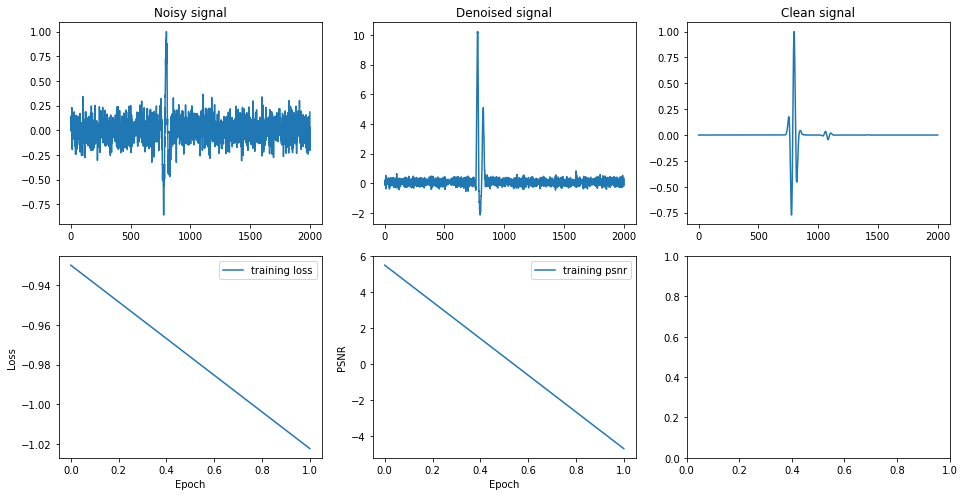

In [128]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp_GAN.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[11][1]))
os.makedirs(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR', exist_ok=True)
plt.savefig(r'C:\Users\bbfss\Desktop\file\Code\github\Denoising-CNN\Denoising-CNN_2.0\结果集\PSNR\{}.svg'.format("FDUDDnCNN_PSNR"))